In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import impyute.imputation as imp
from statsmodels.tsa.stattools import adfuller
import statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

In [3]:
# Função para completar os dados faltantes
def completa_serie(dados,ano):
    print('-'*50)
    print('-'*24,ano,'-'*20)
    print('-'*50)
    
    # Reseta o index da série para ser por linha
    miss_dados = dados.isna().sum().sum()/(dados.shape[0]*dados.shape[1])*100
    print(f'{miss_dados.round(2)}% dos dados da bases são faltantes')
    
    # Completa os dados por Expect Maximization(EM)
    dados_filled = imp.cs.em(dados.values,loops=50)    
    d = [str(i) for i in range(1,25)]
    dados_completados = pd.DataFrame(data=dados_filled.round(0),columns=d)
    
    # Dados completados por EM
    print('*'*40,'  Base de dados completada  ','*'*40)
    display(dados_completados.head())

    # Formato da base dados
    print('*'*40,'  Formato da base dados  ','*'*40)
    display(dados_completados.shape)

    # Média diária dos dados
    print('*'*40,'Média diária dos dados','*'*40)
    dados_medios_completados = dados_completados.mean(axis='columns')
    display(dados_medios_completados)
    
    return dados_medios_completados

# Aplicar o Teste de Dickey-Fuller
def teste_estacionariedade(serie_temporal):
    
    #Teste estatístico
    print('Resultados do teste Dickey Fuller:')
    dftest = adfuller(serie_temporal.values)
    p_value = dftest[1]
    dfoutput = pd.Series(dftest[0:4], index=['Teste estatístico','p-value','#Lags Usados','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valores críticos (%s)'%key] = value
    print(dfoutput)
    return p_value

def MAPE(serie_suavizada,serie_original):
    return sum(abs((serie_suavizada-serie_original)*100)/serie_original)/serie_suavizada.shape[0]

def MQE(serie_suavizada,serie_original):
    return sum(pow(serie_suavizada-serie_original,2))/serie_suavizada.shape[0]

def MAE(serie_suavizada,serie_original):
    return sum(abs(serie_suavizada-serie_original))/serie_suavizada.shape[0]


def alisar_serie(serie_temporal_n_tratada,p_value,alpha=0.3):
    df_modelo_suavisado,df_suavisado = pd.DataFrame({}),pd.DataFrame({})
    vMAPE,vMAE,vMQE = [],[],[]
    
    if p_value < 0.05:
        janelas = [5,15,25,35,45,55,65,75]
        for janela in janelas:
            #Média movel para séries estácionária
            modelo_suavisado = serie_temporal_n_tratada.rolling(janela).mean()
            
            modelo_suavisado.reset_index(drop=True,inplace=True)
            modelo_suavisado.dropna(inplace=True)
            df_modelo_suavisado = df_modelo_suavisado.append(modelo_suavisado,ignore_index=True)
            
            vMAPE.append(MAPE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            vMAE.append(MAE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            vMQE.append(MQE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            
        moda = statistics.mode([vMAPE.index(min(vMAPE)),vMAE.index(min(vMAE)),vMQE.index(min(vMQE))])
        df_modelo_suavisado = df_modelo_suavisado.T
        df_suavisado = df_modelo_suavisado[moda].dropna()
        
    elif p_value > 0.05:
            modelo_suavisado = [serie_temporal_n_tratada[0]] # first value is same as series
            for n in range(1, len(serie_temporal_n_tratada)):
                modelo_suavisado.append(alpha * serie_temporal_n_tratada[n] + (1 - alpha) * modelo_suavisado[n-1])                
            df_suavisado = df_suavisado.append(modelo_suavisado,ignore_index=True)
            vMAPE.append(MAPE(df_suavisado,serie_temporal_n_tratada))
            vMAE.append(MAE(df_suavisado,serie_temporal_n_tratada))
            vMQE.append(MQE(df_suavisado,serie_temporal_n_tratada))

    
    print(f'MAPE:{min(vMAPE)}')
    print(f'MAE:{min(vMAE)}')
    print(f'MQE:{min(vMQE)}')
    #Plotar valores para verficar visualmente
    plt.figure(figsize=(40,5))
    st_plot = plt.plot(serie_temporal_n_tratada,'*-', color='red',label='Original')
    st_plot = plt.plot(df_suavisado,'*-', color='blue',label='Suavizado')
    plt.legend(loc='best')
    plt.show(block=False)
    
    return df_suavisado

# Etapa 1: Carregar os dados

In [4]:
dados2016 = pd.read_csv('..\/01.Dados\/CSV\/MP10_nossa_S_2016.csv')
dados2017 = pd.read_csv('..\/01.Dados\/CSV\/MP10_nossa_S_2017.csv')
dados2018 = pd.read_csv('..\/01.Dados\/CSV\/MP10_nossa_S_2018.csv')
dados2019 = pd.read_csv('..\/01.Dados\/CSV\/MP10_nossa_S_2019.csv')
dados2020 = pd.read_csv('..\/01.Dados\/CSV\/MP10_nossa_S_2020.csv')

# Etapa 2: Tratamento de dados faltantes

In [5]:
dados_medios_completados_2016 = completa_serie(dados2016,2016)
dados_medios_completados_2017 = completa_serie(dados2017,2017)
dados_medios_completados_2018 = completa_serie(dados2018,2018)
dados_medios_completados_2019 = completa_serie(dados2019,2019)
dados_medios_completados_2020 = completa_serie(dados2020,2020)

--------------------------------------------------
------------------------ 2016 --------------------
--------------------------------------------------
12.48% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1      2     3     4     5     6     7     8     9    10  ...    15  \
0  96.0  121.0  28.0  18.0   2.0  11.0  14.0   5.0   5.0  13.0  ...  13.0   
1  82.0   18.0  16.0   6.0   8.0   8.0  13.0   9.0  12.0  10.0  ...   6.0   
2  25.0   16.0   9.0   9.0   6.0  13.0   3.0  10.0   5.0  15.0  ...  11.0   
3  52.0   19.0  10.0  14.0   5.0  19.0  63.0  50.0  14.0  27.0  ...  18.0   
4  70.0   27.0  11.0  10.0  23.0  12.0  14.0  18.0  15.0  17.0  ...  22.0   

     16    17    18    19    20    21    22    23    24  
0  13.0  15.0   4.0   8.0   9.0   7.0  14.0   6.0  17.0  
1   7.0   7.0   5.0   8.0   1.0   6.0  10.0   2.0   5.0  
2   8.0  16.0  14.0  11.0   3.0   9.0   4.0  12.0   2.0  
3  13.0  20.0  16.0  22.0  19.0   8.0  21.0   9.0  14.0  
4  15.0  21.0  27.0  30.0  20.0  24.0  21.0  20.0  21.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(213, 24)

**************************************** Média diária dos dados ****************************************


0      18.916667
1      11.000000
2       9.791667
3      20.791667
4      21.541667
         ...    
208    36.833333
209    29.375000
210    26.000000
211    37.083333
212    43.000000
Length: 213, dtype: float64

--------------------------------------------------
------------------------ 2017 --------------------
--------------------------------------------------
0.2% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1      2     3     4     5     6     7     8     9    10  ...    15  \
0  175.0  242.0  33.0  39.0  36.0  35.0  27.0  20.0  12.0  17.0  ...   9.0   
1   11.0   25.0  15.0  12.0   9.0   9.0   9.0  15.0  19.0  18.0  ...  12.0   
2   11.0   19.0  10.0  15.0  16.0  22.0  26.0  26.0  27.0  28.0  ...  16.0   
3   16.0   19.0  21.0  14.0  16.0  22.0  16.0  15.0  25.0  14.0  ...  21.0   
4   33.0   29.0  23.0  21.0  27.0  25.0  29.0  25.0  22.0  21.0  ...  25.0   

     16    17    18    19    20    21    22    23    24  
0  13.0  16.0  32.0   7.0  14.0  22.0  16.0  20.0  13.0  
1  25.0  19.0  29.0  20.0  15.0  13.0   6.0  11.0  17.0  
2  25.0  49.0  37.0  29.0  21.0  20.0  11.0   7.0  12.0  
3  19.0  17.0  21.0  29.0  29.0  21.0  30.0  28.0  20.0  
4  40.0  35.0  24.0  18.0  14.0  17.0  18.0  27.0  25.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      35.291667
1      15.125000
2      22.708333
3      19.583333
4      23.666667
         ...    
207    38.750000
208    38.750000
209    35.708333
210    26.666667
211    36.416667
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2018 --------------------
--------------------------------------------------
2.73% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1     2     3     4     5     6     7     8     9    10  ...    15  \
0  48.0  58.0  33.0  26.0  13.0  15.0   9.0   9.0   7.0   8.0  ...  11.0   
1  16.0   9.0  14.0   8.0  11.0   9.0   7.0   8.0   9.0  12.0  ...  23.0   
2   7.0   5.0   6.0   9.0   4.0  13.0   9.0  14.0   6.0  10.0  ...   9.0   
3  20.0  24.0  16.0  15.0  12.0  12.0  18.0  14.0  17.0  19.0  ...  14.0   
4   6.0  19.0  17.0  22.0  24.0  11.0  16.0  13.0  17.0  14.0  ...  15.0   

     16    17    18    19    20    21    22    23    24  
0  14.0   7.0   8.0  11.0   8.0  16.0  19.0  19.0   9.0  
1   7.0   9.0   8.0  19.0  14.0  11.0  10.0   5.0   8.0  
2   5.0  11.0  10.0  11.0  13.0   8.0   9.0  10.0  13.0  
3  13.0  15.0  23.0  28.0  31.0  38.0  18.0  20.0  15.0  
4  19.0  33.0  33.0  31.0  31.0  36.0  37.0  38.0  41.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      15.625000
1      10.750000
2       8.375000
3      17.958333
4      22.125000
         ...    
207    57.916667
208    63.875000
209    82.791667
210    53.250000
211    12.000000
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2019 --------------------
--------------------------------------------------
6.58% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1     2      3     4     5     6     7     8     9    10  ...    15  \
0  67.0  97.0  109.0  71.0  45.0  52.0  28.0  18.0  19.0  11.0  ...  15.0   
1  34.0  23.0   20.0  22.0  21.0  20.0  29.0  19.0  15.0  23.0  ...   6.0   
2  25.0  21.0   17.0  15.0  11.0   9.0   8.0   9.0  11.0  15.0  ...  21.0   
3   2.0   7.0    4.0   4.0   6.0   8.0   3.0  13.0   7.0   6.0  ...  24.0   
4   7.0   9.0    9.0   6.0  11.0  13.0   6.0  10.0   9.0  10.0  ...   1.0   

     16    17    18    19    20    21    22    23    24  
0  19.0  69.0  39.0  19.0  12.0   9.0  31.0  24.0  29.0  
1  12.0   6.0  24.0  23.0   9.0  13.0  33.0  37.0  28.0  
2  12.0  22.0  21.0  30.0  34.0   5.0   8.0   6.0   3.0  
3  27.0   7.0  11.0  22.0  16.0  11.0   9.0  13.0   7.0  
4   8.0  11.0   8.0   6.0   9.0  13.0  24.0  27.0   9.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      34.500000
1      19.083333
2      15.791667
3      11.333333
4       9.416667
         ...    
207    38.333333
208    25.541667
209    32.875000
210    37.208333
211    31.041667
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2020 --------------------
--------------------------------------------------
16.16% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1      2      3      4     5     6     7     8     9    10  ...    15  \
0  73.0  174.0  107.0  106.0  56.0  48.0  17.0  10.0   7.0  11.0  ...  29.0   
1  10.0    9.0    7.0   14.0   6.0   8.0   8.0  18.0   5.0  18.0  ...  27.0   
2  11.0    4.0   10.0    1.0   3.0   6.0   2.0   4.0   2.0   8.0  ...  10.0   
3  17.0    7.0   15.0    7.0  12.0   9.0  15.0  15.0  10.0  14.0  ...  28.0   
4  11.0   15.0    8.0   17.0  11.0  12.0  12.0  18.0   9.0  16.0  ...  10.0   

     16    17    18    19    20    21    22   23   24  
0  58.0  39.0  18.0  25.0  14.0   2.0   3.0  3.0  2.0  
1  43.0   6.0   5.0  10.0   1.0   3.0   1.0  6.0  3.0  
2  23.0  15.0   5.0   9.0   4.0   6.0   5.0  8.0  5.0  
3  19.0  19.0   4.0   2.0   6.0   5.0  10.0  7.0  2.0  
4  25.0  42.0  20.0   6.0   7.0  10.0   8.0  6.0  0.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(213, 24)

**************************************** Média diária dos dados ****************************************


0      37.291667
1      12.041667
2       7.375000
3      11.500000
4      13.416667
         ...    
208    32.541667
209    50.250000
210    15.458333
211    10.125000
212    11.958333
Length: 213, dtype: float64

# Etapa 3: Decompondo cada série

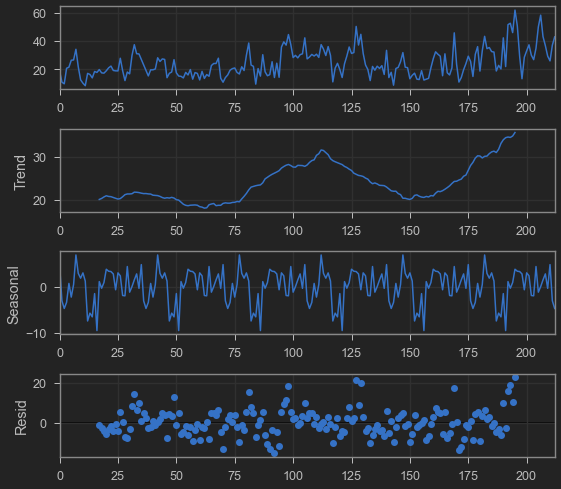

In [6]:
resultado_2016 = seasonal_decompose(dados_medios_completados_2016,period=35)
resultado_2016.plot();

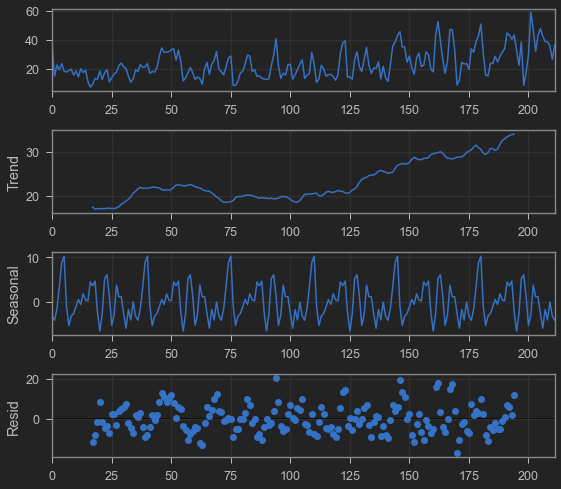

In [7]:
resultado_2017 = seasonal_decompose(dados_medios_completados_2017,period=35)
resultado_2017.plot();

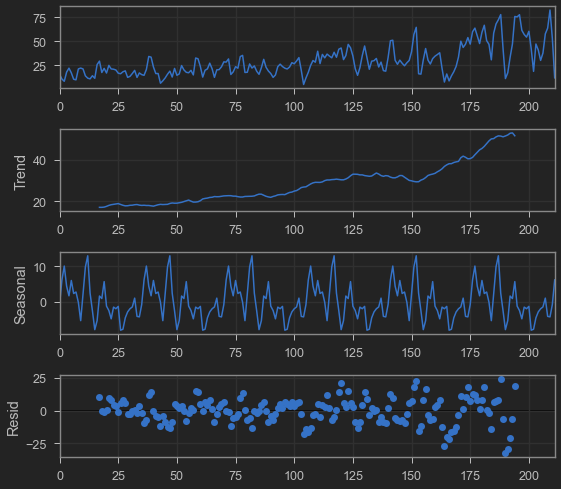

In [8]:
resultado_2018 = seasonal_decompose(dados_medios_completados_2018,period=35)
resultado_2018.plot();

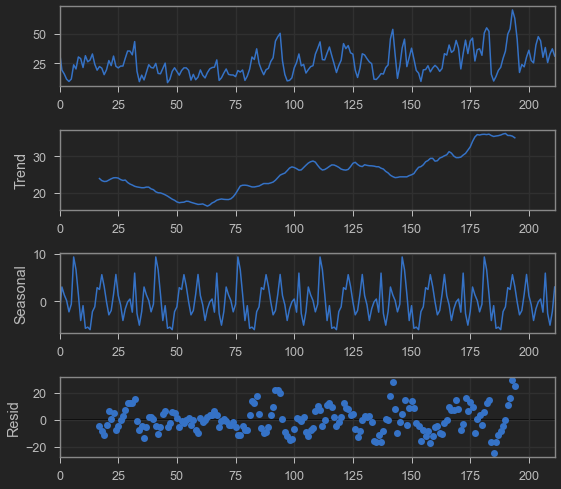

In [9]:
resultado_2019 = seasonal_decompose(dados_medios_completados_2019,period=35)
resultado_2019.plot();

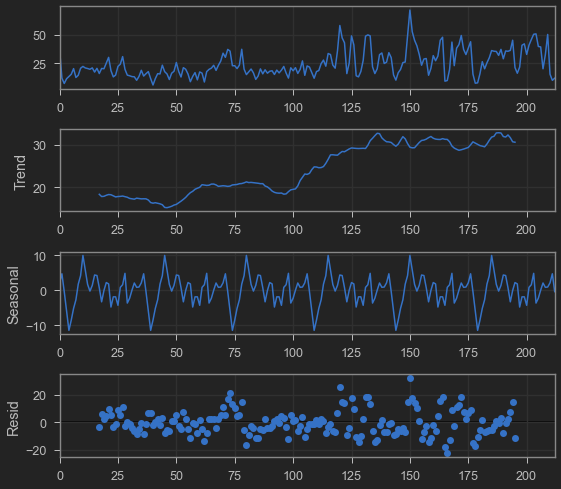

In [10]:
resultado_2020 = seasonal_decompose(dados_medios_completados_2020,period=35)
resultado_2020.plot();

# Etapa 4: Teste Estacionariedade da série
## **Teste de Dickey-Fuller**

Pode ser tamém chamdo de ADF(Augmented Dickey-Fuller):

$\Delta y_t = \beta_t + \beta_{2t} + \delta_{yt-1} + \sum_{i=1}^{m}{\alpha_i \Delta_{yt-1} + \epsilon_t}$

$\beta_1$ - intercepto drift da série

$\beta_2$ - intercepto de tendência

$\delta$  - coeficiente de presença de raiz.

m - número de defasagens tomadas na série.


+ Hipótese nula é se $\delta$ = 0;

Fazemos a regressão de $\Delta_{y_t}$ em que $y_{t-1}$ e repetindo em $\Delta_{y_{t-1}}$ em que $y_{t-2}$ e assim sucesivamente e calculamos a estatística T dada por:

$T = \frac{\delta}{se(\delta)}$

$\^\delta$ - estimador de $\delta$

$se(\^ \delta)$ - estimador do desvio padrão do erro de $\delta$

Resultados do teste Dickey Fuller:
Teste estatístico                -5.438552
p-value                           0.000003
#Lags Usados                      1.000000
Número de observações usadas    211.000000
Valores críticos (1%)            -3.461727
Valores críticos (5%)            -2.875337
Valores críticos (10%)           -2.574124
dtype: float64


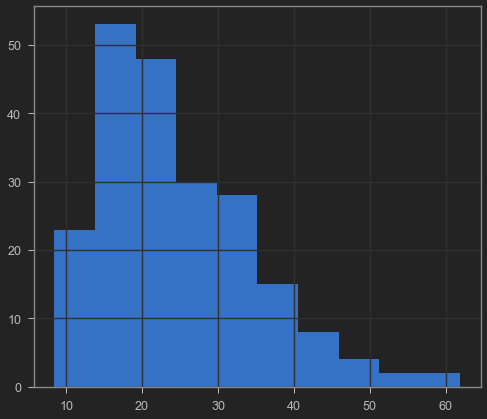

In [11]:
p_v_2016 = teste_estacionariedade(dados_medios_completados_2016)
dados_medios_completados_2016.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -0.945515
p-value                           0.772615
#Lags Usados                     12.000000
Número de observações usadas    199.000000
Valores críticos (1%)            -3.463645
Valores críticos (5%)            -2.876176
Valores críticos (10%)           -2.574572
dtype: float64


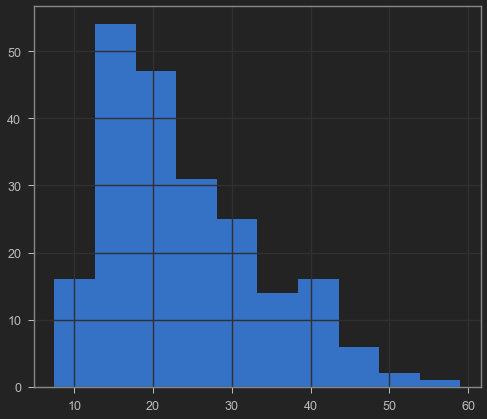

In [12]:
p_v_2017 = teste_estacionariedade(dados_medios_completados_2017)
dados_medios_completados_2017.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -1.723786
p-value                           0.418901
#Lags Usados                      8.000000
Número de observações usadas    203.000000
Valores críticos (1%)            -3.462980
Valores críticos (5%)            -2.875885
Valores críticos (10%)           -2.574416
dtype: float64


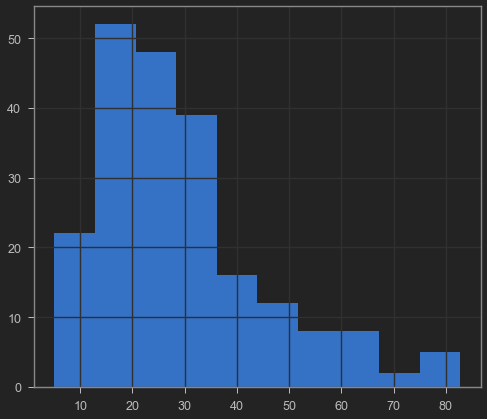

In [13]:
p_v_2018 = teste_estacionariedade(dados_medios_completados_2018)
dados_medios_completados_2018.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -2.722839
p-value                           0.070169
#Lags Usados                      8.000000
Número de observações usadas    203.000000
Valores críticos (1%)            -3.462980
Valores críticos (5%)            -2.875885
Valores críticos (10%)           -2.574416
dtype: float64


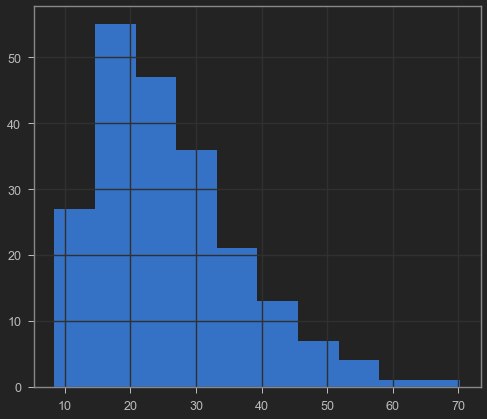

In [14]:
p_v_2019 = teste_estacionariedade(dados_medios_completados_2019)
dados_medios_completados_2019.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -4.318801
p-value                           0.000412
#Lags Usados                      3.000000
Número de observações usadas    209.000000
Valores críticos (1%)            -3.462032
Valores críticos (5%)            -2.875471
Valores críticos (10%)           -2.574195
dtype: float64


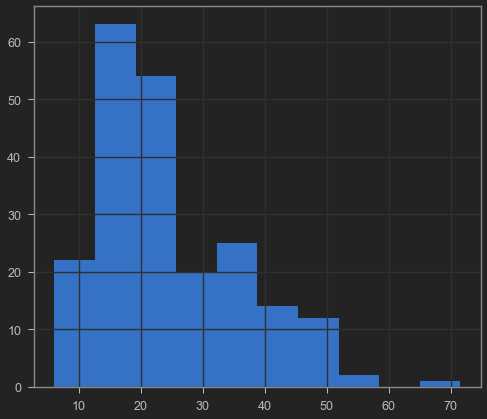

In [15]:
p_v_2020 = teste_estacionariedade(dados_medios_completados_2020)
dados_medios_completados_2020.hist()

# Etapa 5: Autocorrelação para verificar a periodicidade e sazonalidade da série

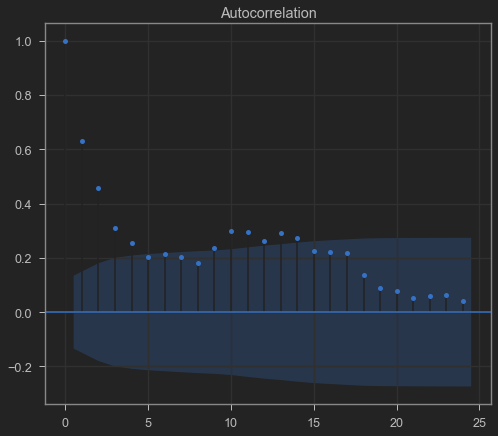

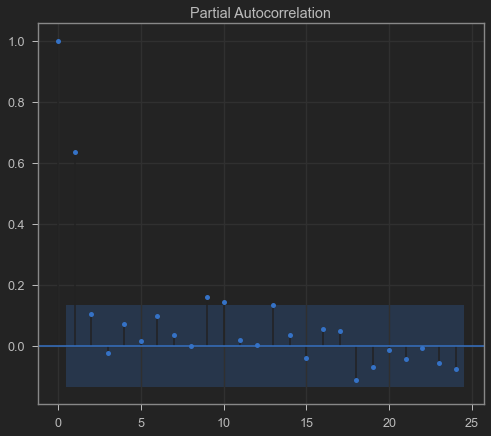

In [16]:
plot_acf(dados_medios_completados_2016);
plot_pacf(dados_medios_completados_2016);

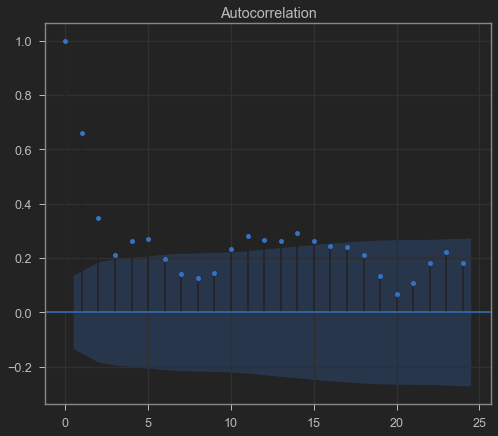

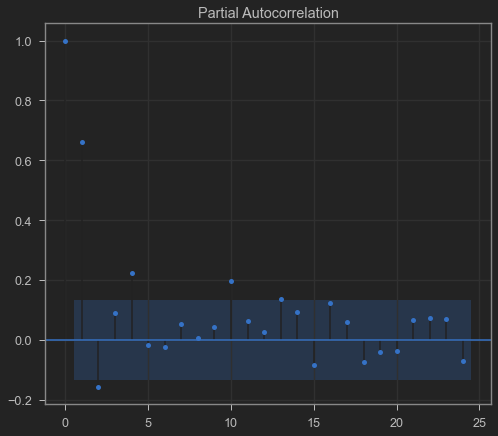

In [17]:
plot_acf(dados_medios_completados_2017);
plot_pacf(dados_medios_completados_2017);

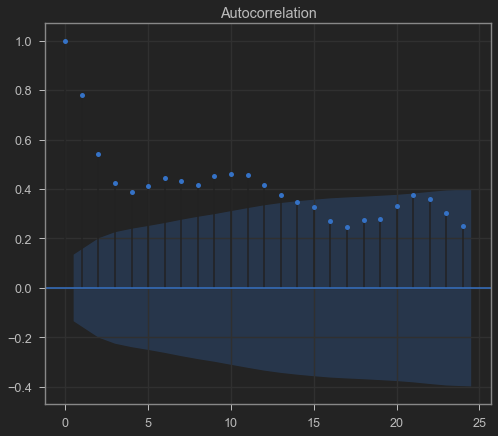

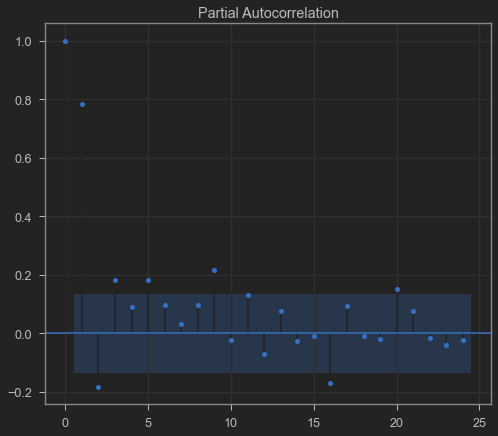

In [18]:
plot_acf(dados_medios_completados_2018);
plot_pacf(dados_medios_completados_2018);

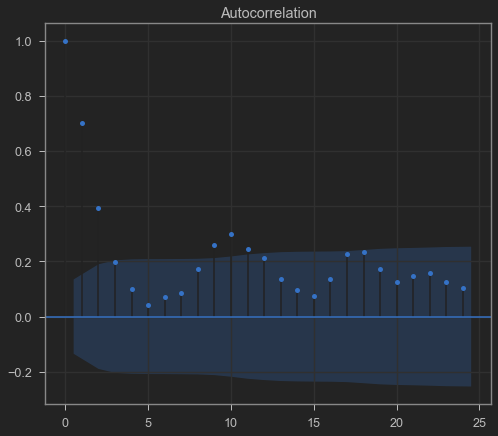

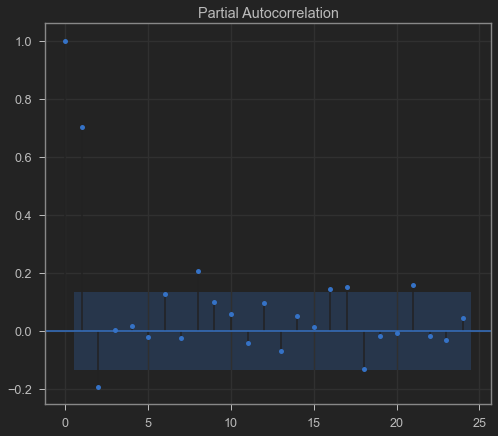

In [19]:
plot_acf(dados_medios_completados_2019);
plot_pacf(dados_medios_completados_2019);

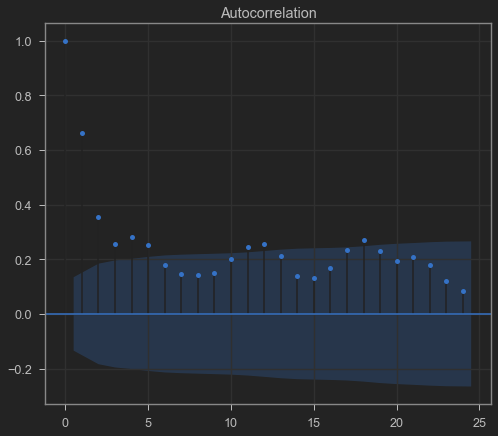

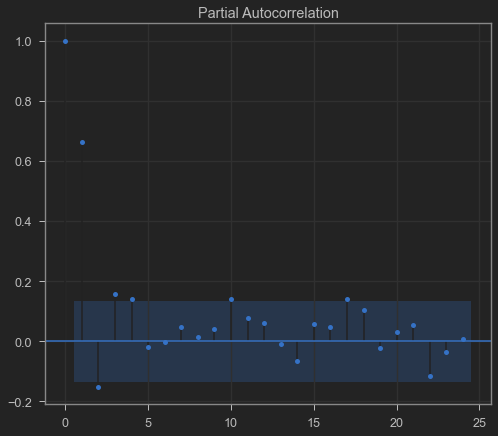

In [20]:
plot_acf(dados_medios_completados_2020);
plot_pacf(dados_medios_completados_2020);

# Etapa 6: Verificando variação nos dados - velocidade de mudança

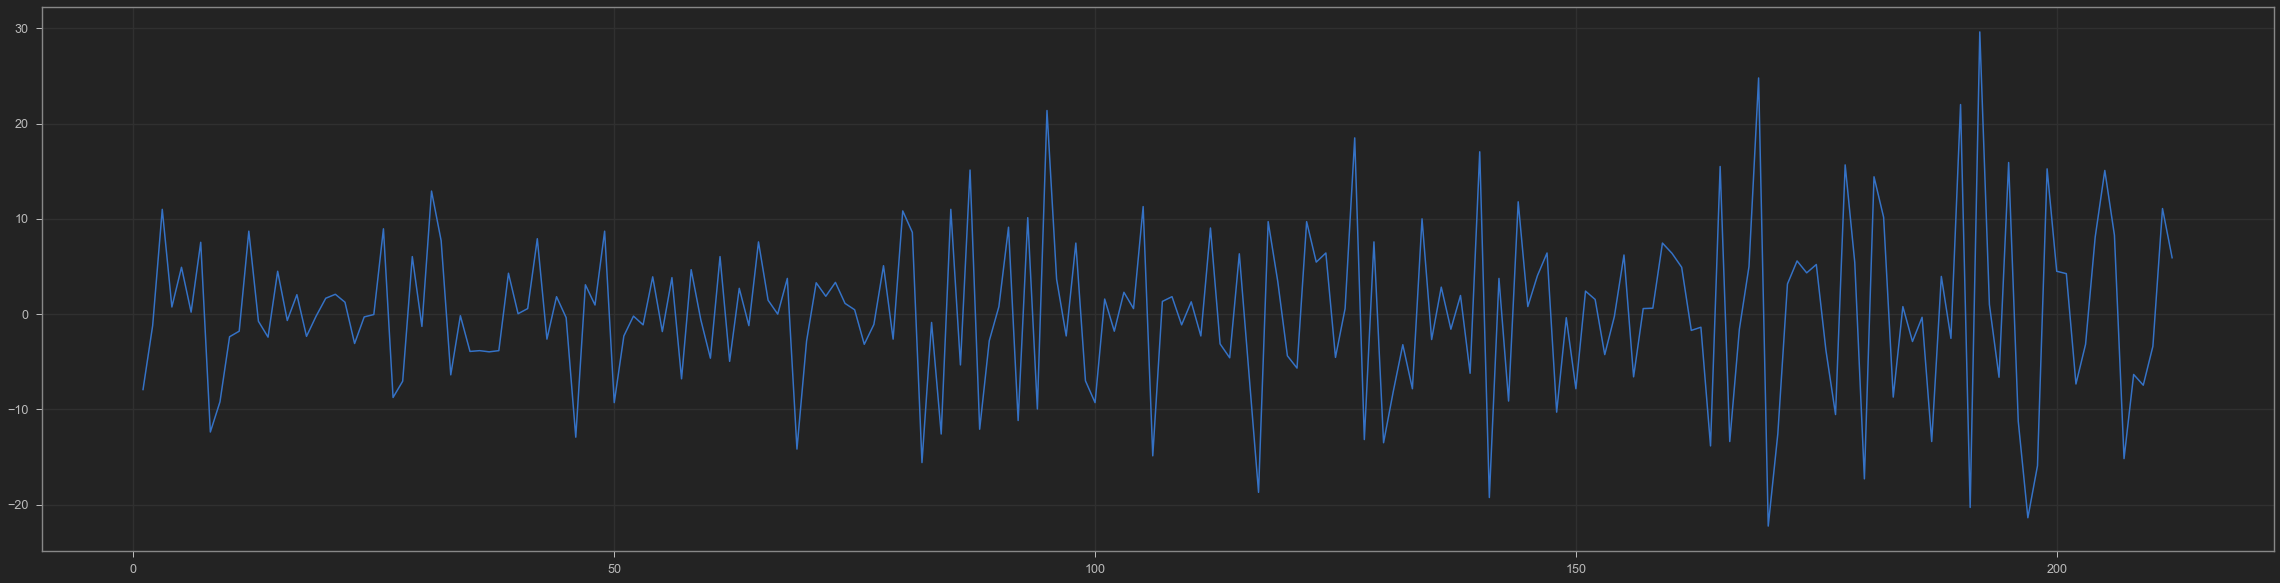

In [21]:
plt.figure(figsize=(40,10))
plt.plot(dados_medios_completados_2016.diff());

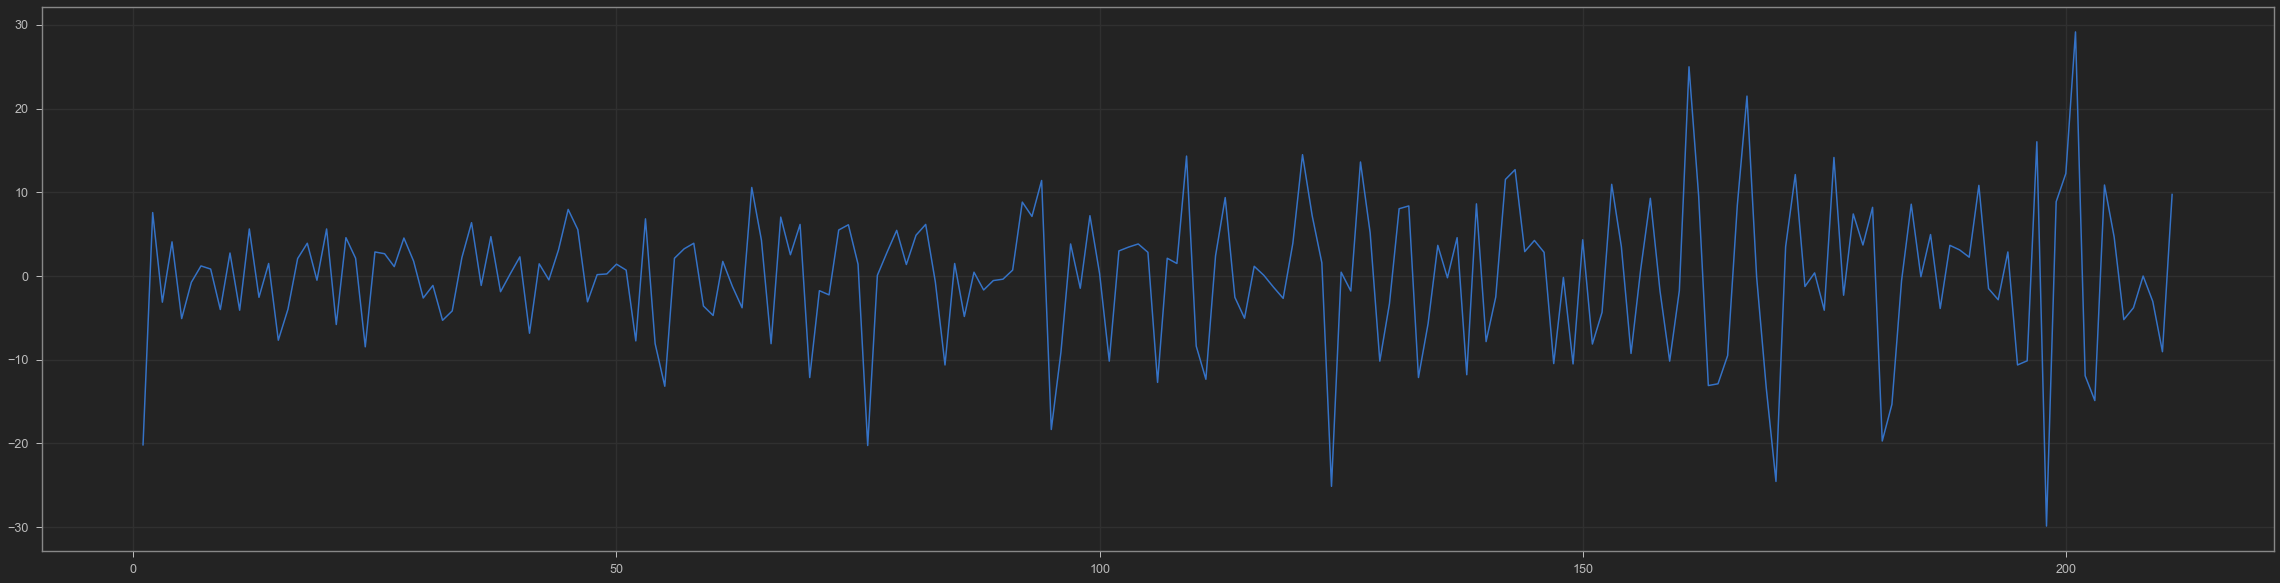

In [22]:
plt.figure(figsize=(40,10))
plt.plot(dados_medios_completados_2017.diff());

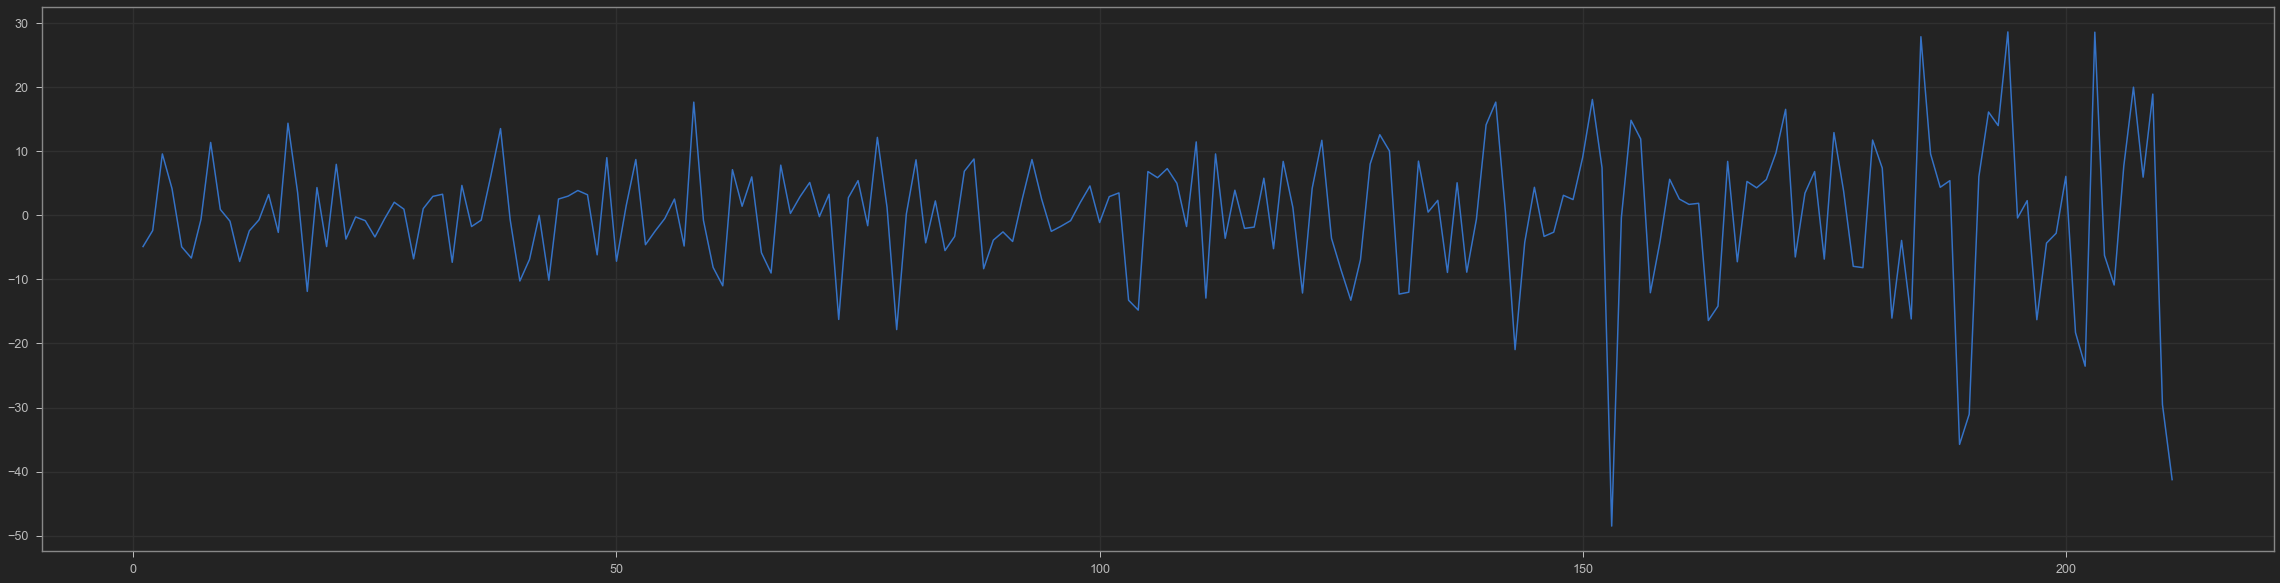

In [23]:
plt.figure(figsize=(40,10))
plt.plot(dados_medios_completados_2018.diff());

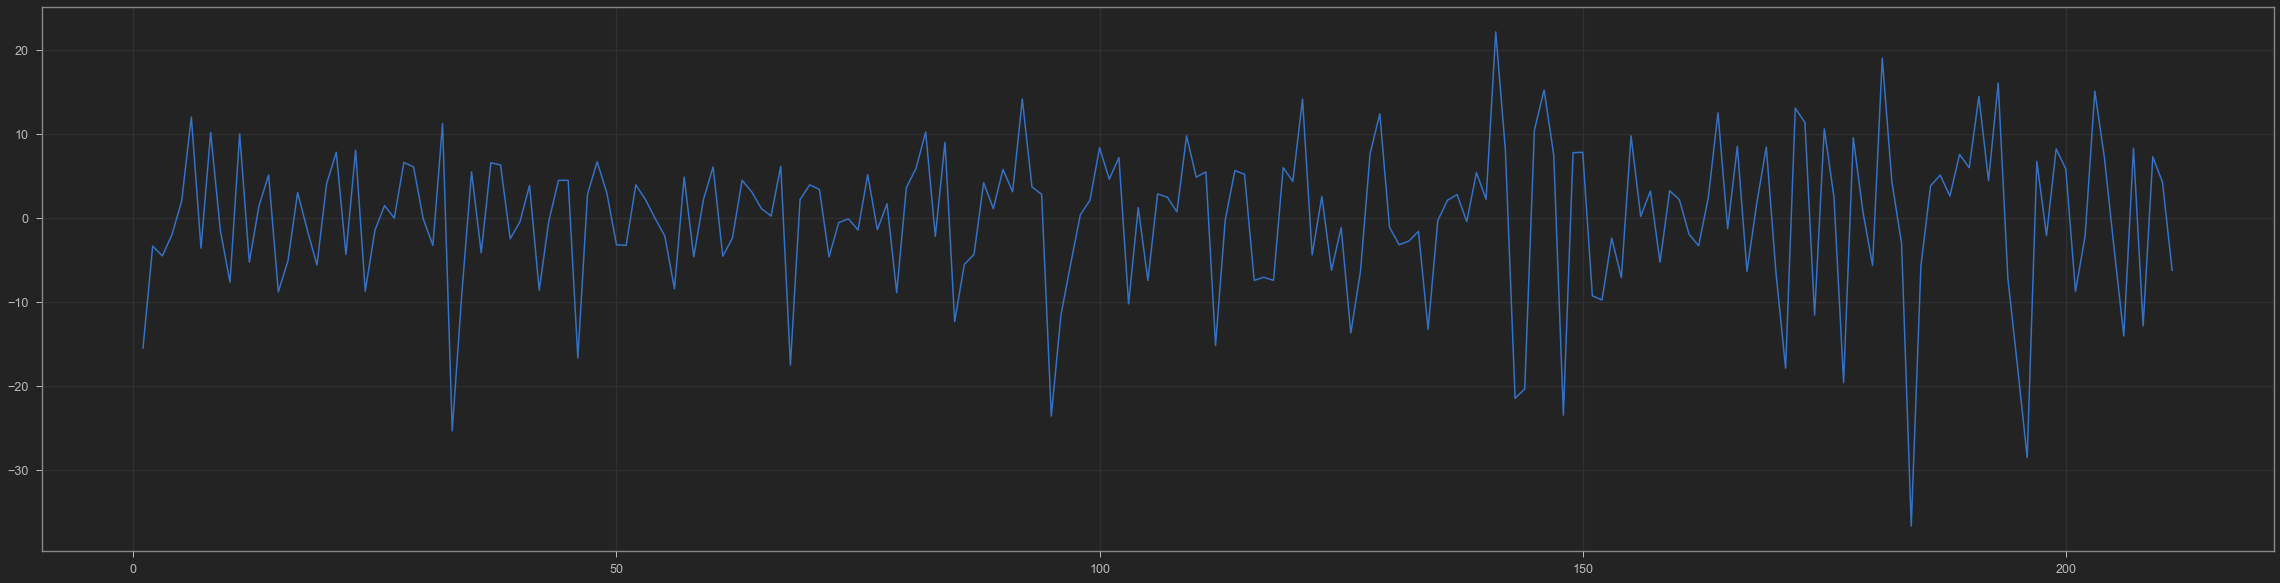

In [24]:
plt.figure(figsize=(40,10))
plt.plot(dados_medios_completados_2019.diff());

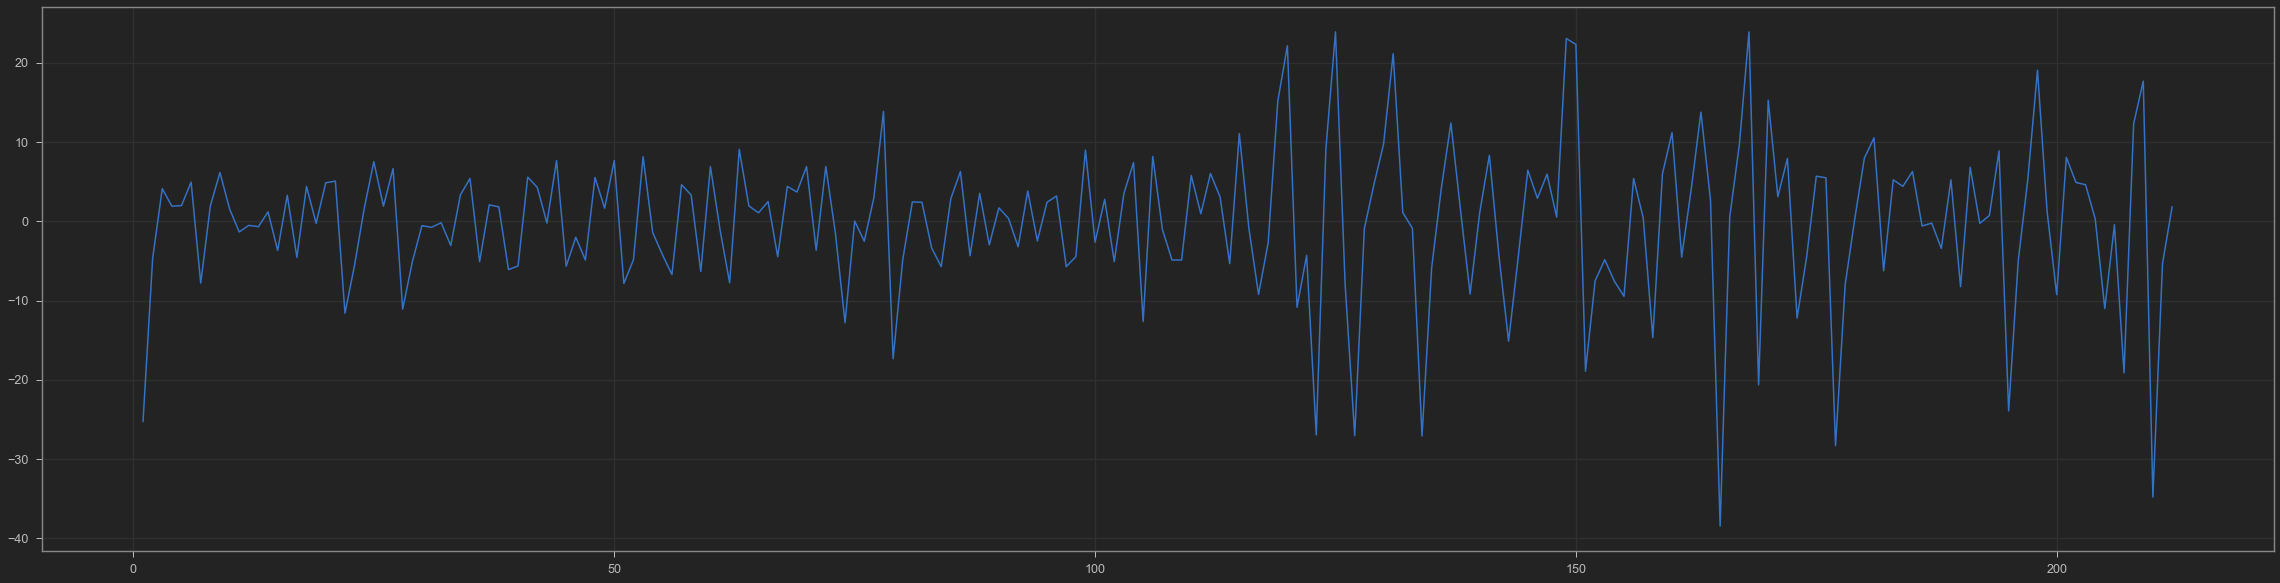

In [25]:
plt.figure(figsize=(40,10))
plt.plot(dados_medios_completados_2020.diff());

# Etapa 6: Verificando variação nos dados - aceleração de mudança

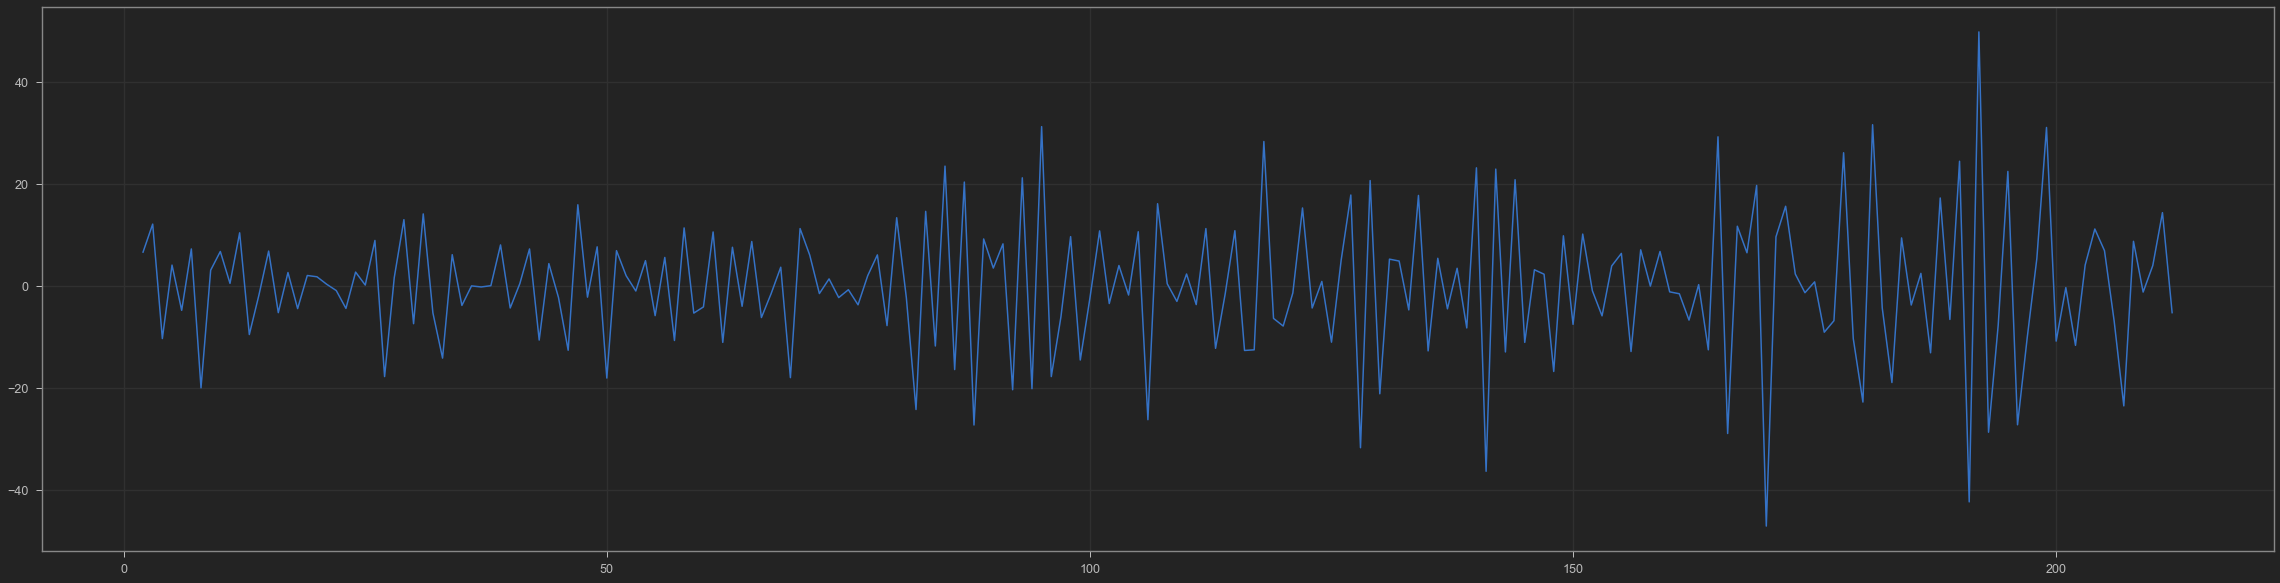

In [26]:
plt.figure(figsize=(40,10))
velocidade_2016 = dados_medios_completados_2016.diff()
plt.plot(velocidade_2016.diff());

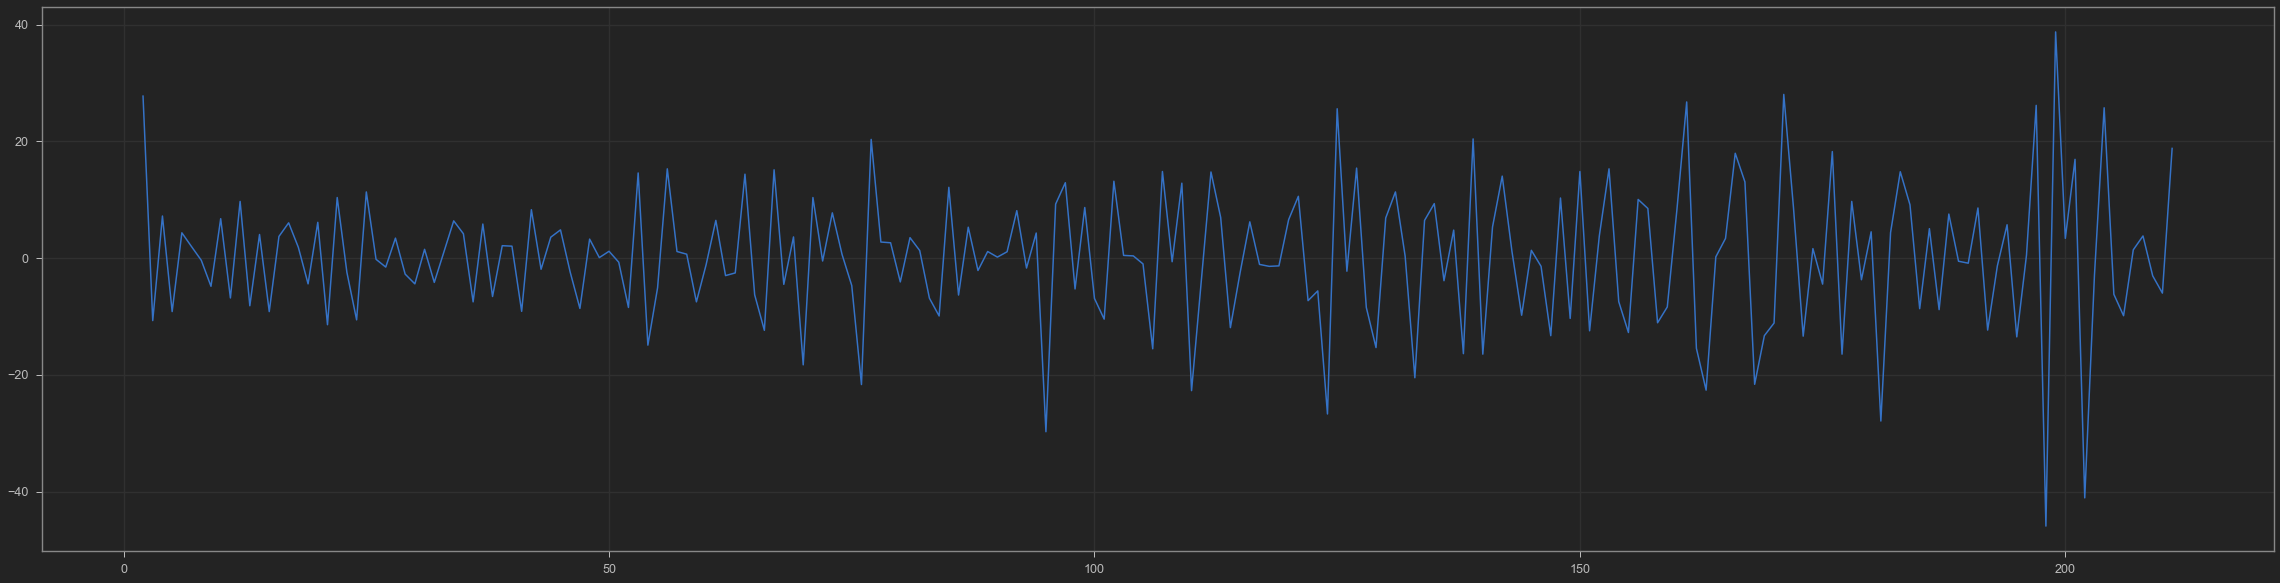

In [27]:
plt.figure(figsize=(40,10))
velocidade_2017 = dados_medios_completados_2017.diff()
plt.plot(velocidade_2017.diff());

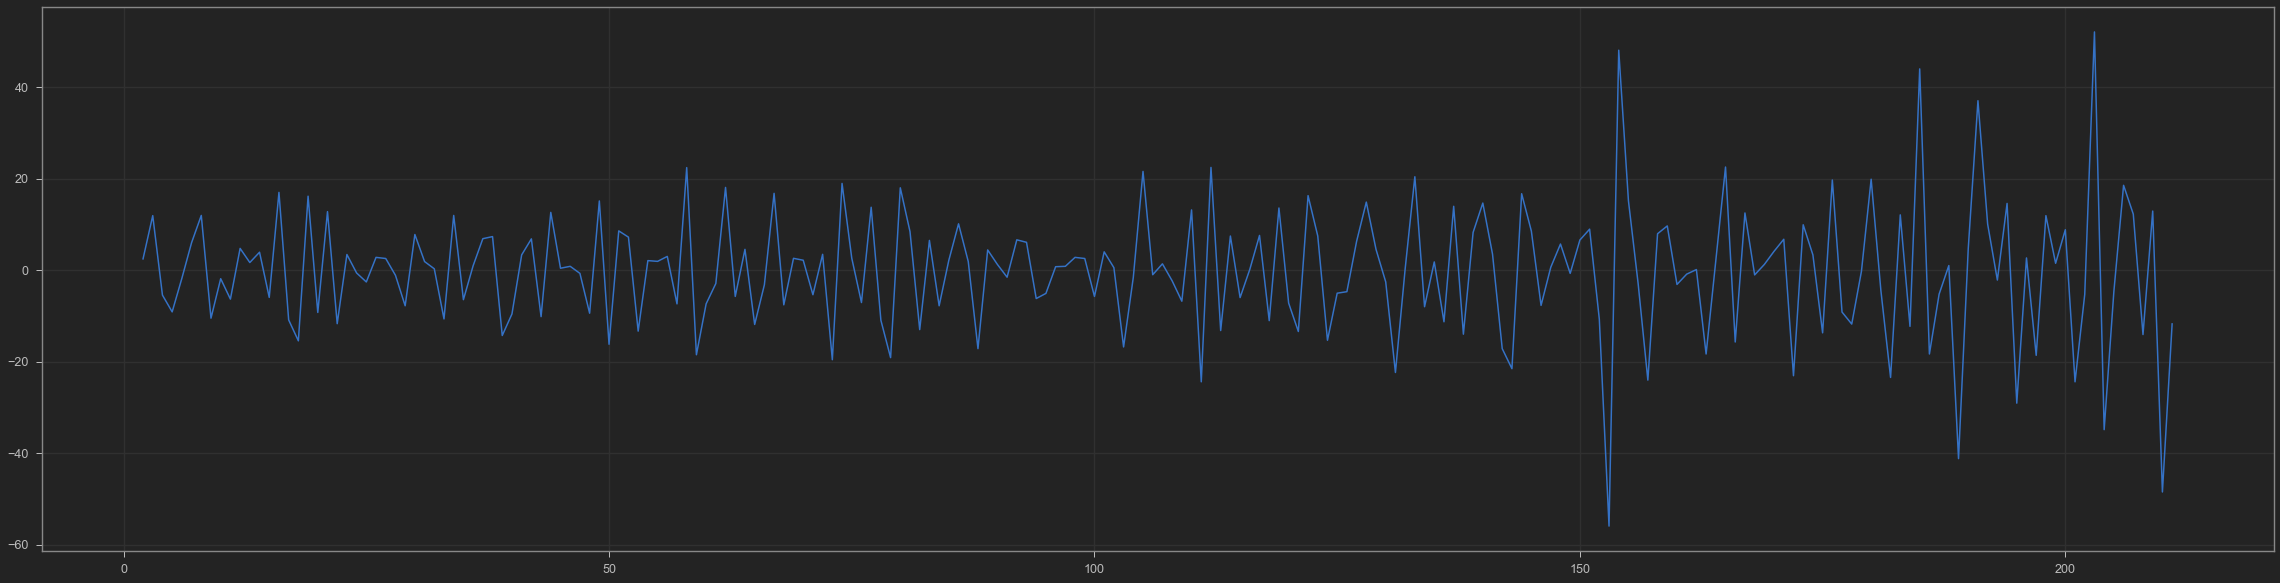

In [28]:
plt.figure(figsize=(40,10))
velocidade_2018 = dados_medios_completados_2018.diff()
plt.plot(velocidade_2018.diff());

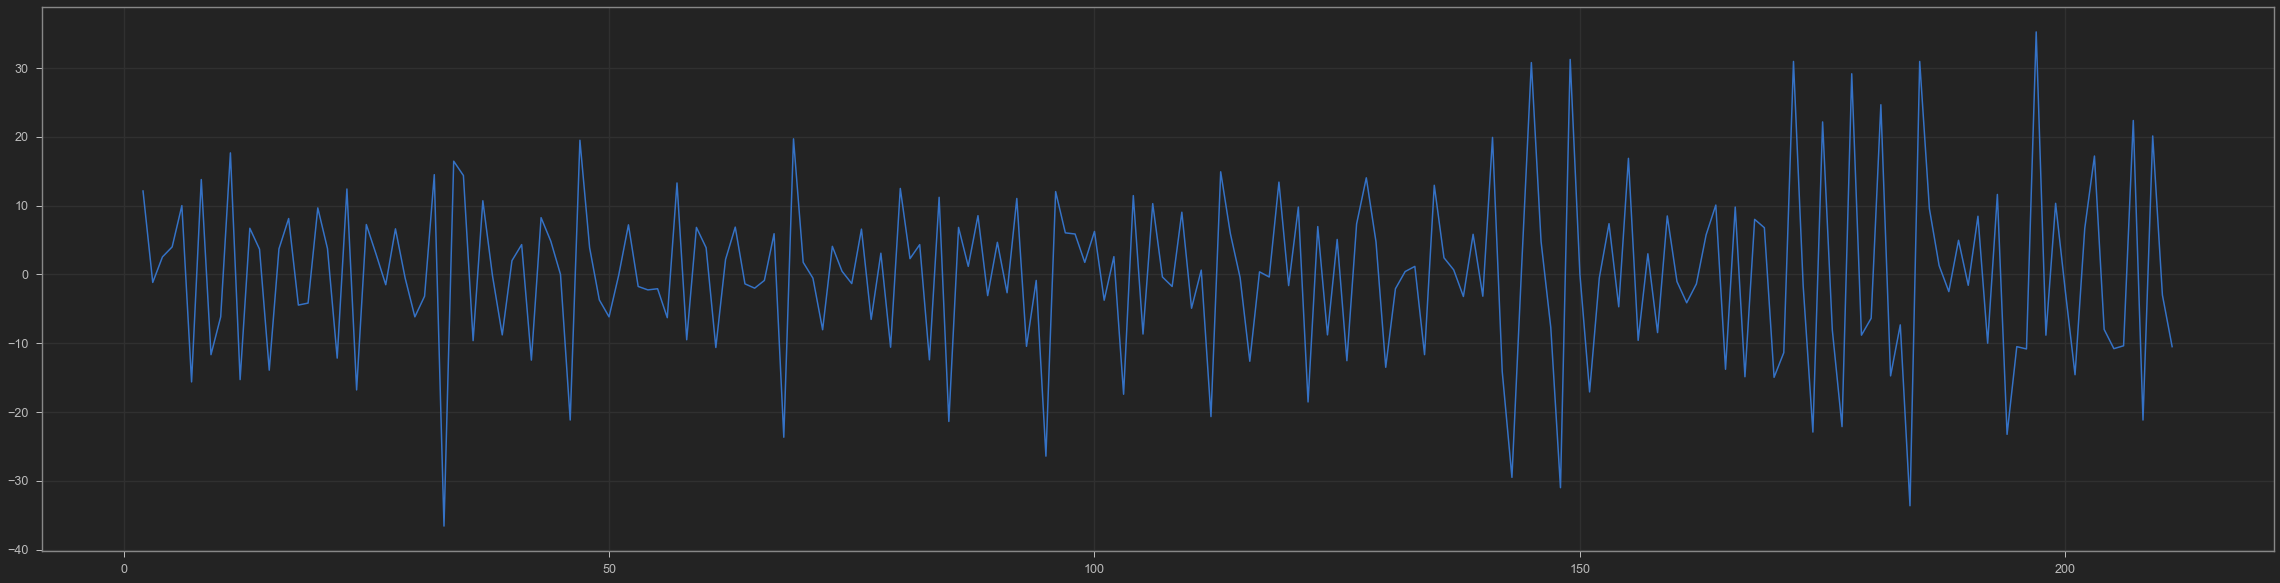

In [29]:
plt.figure(figsize=(40,10))
velocidade_2019 = dados_medios_completados_2019.diff()
plt.plot(velocidade_2019.diff());

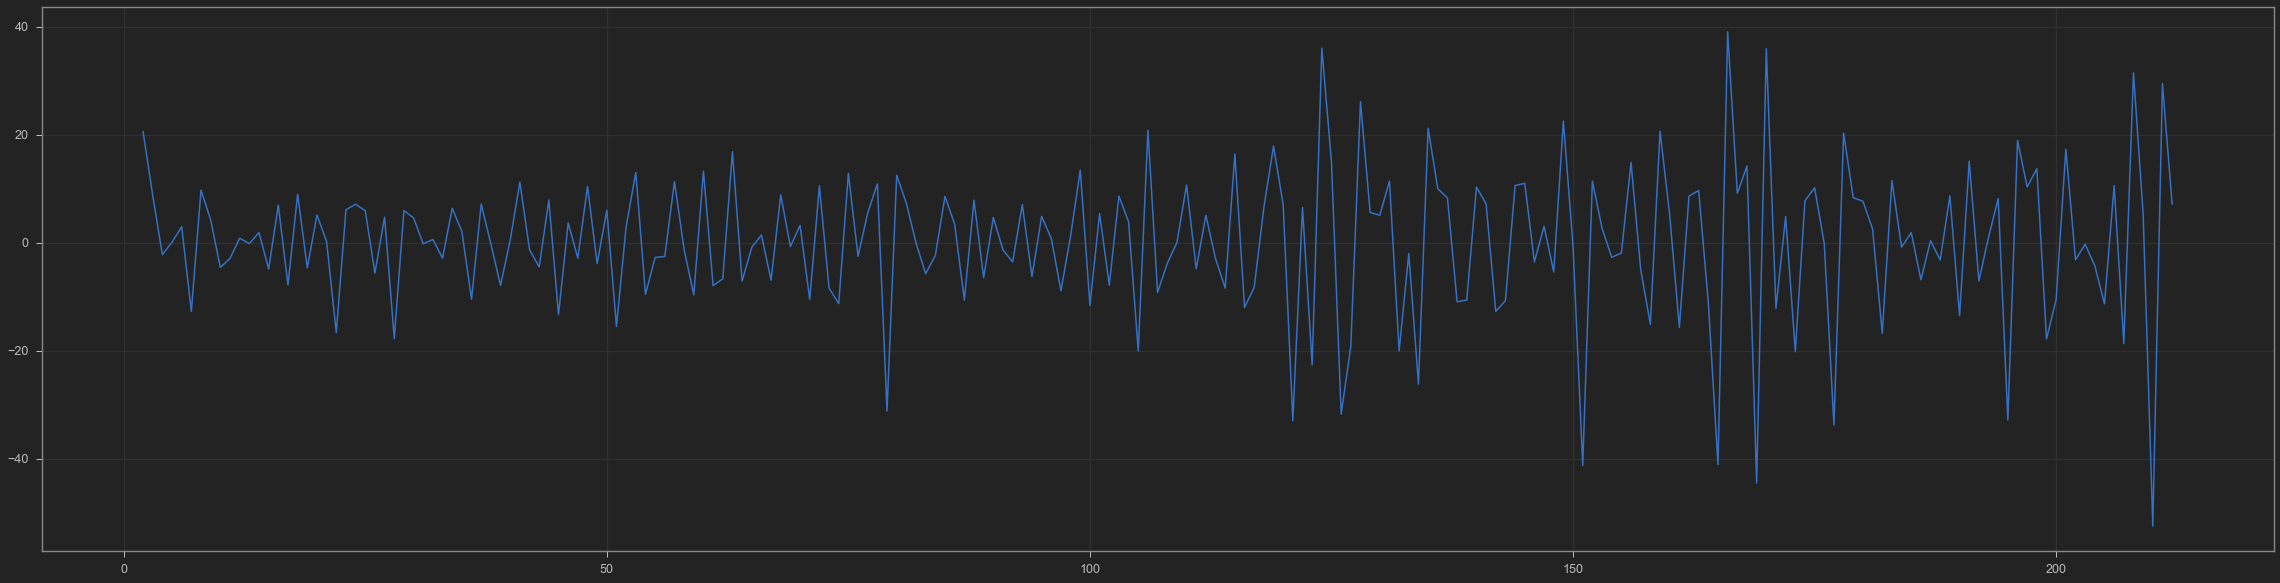

In [30]:
plt.figure(figsize=(40,10))
velocidade_2020 = dados_medios_completados_2020.diff()
plt.plot(velocidade_2020.diff());

# Etapa 7: Autocorrelação da série

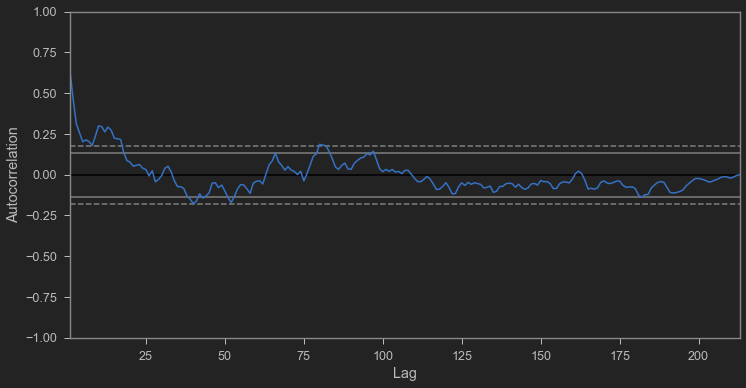

In [31]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2016)

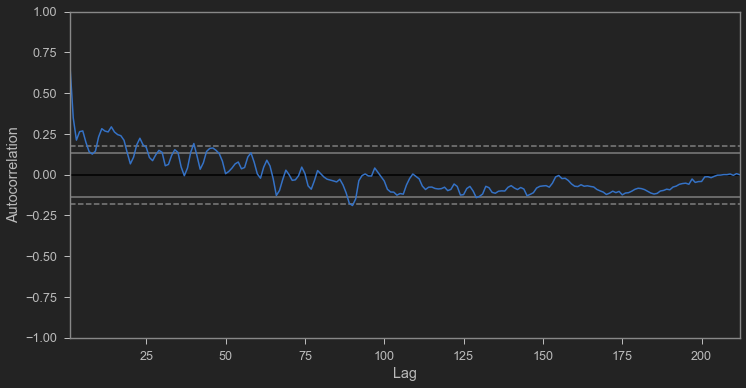

In [32]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2017)

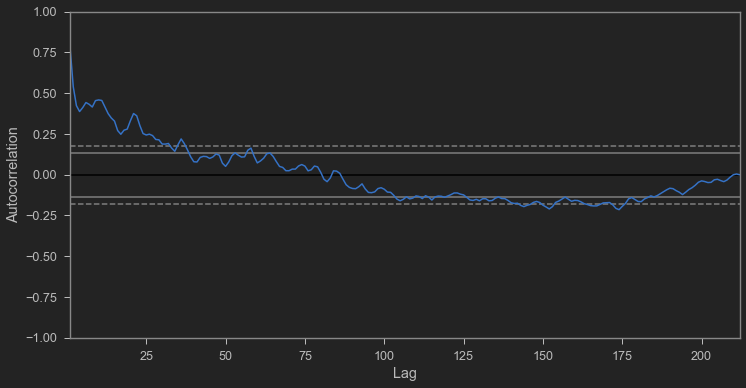

In [33]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2018)

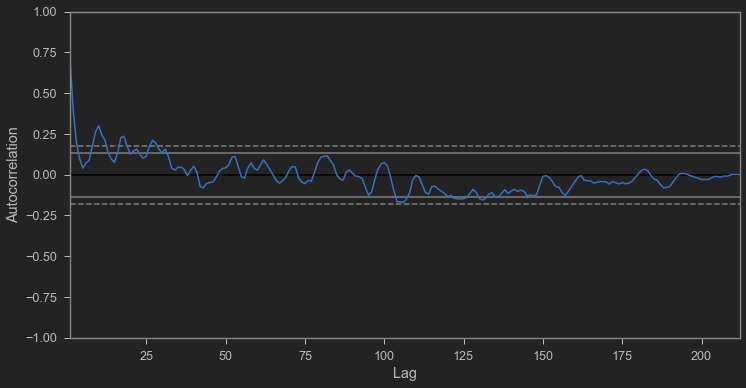

In [34]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2019)

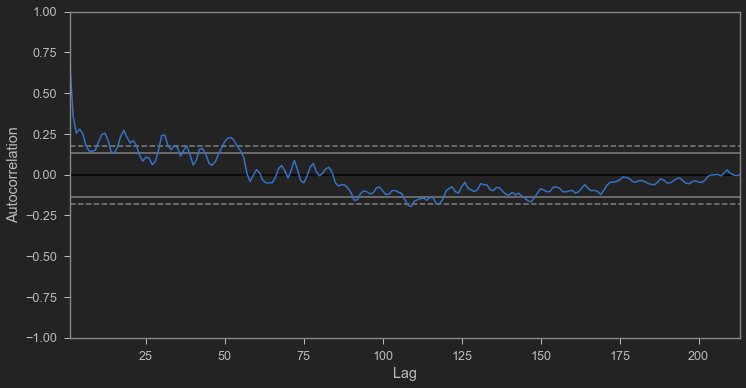

In [35]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2020)

# Parte 2: Juntando os dados

In [36]:
serie_completa = dados_medios_completados_2017
serie_completa = serie_completa.append(dados_medios_completados_2018)
serie_completa = serie_completa.append(dados_medios_completados_2019)
serie_completa = serie_completa.append(dados_medios_completados_2020)
serie_completa.reset_index(drop=True,inplace=True)
serie_completa

0      35.291667
1      15.125000
2      22.708333
3      19.583333
4      23.666667
         ...    
844    32.541667
845    50.250000
846    15.458333
847    10.125000
848    11.958333
Length: 849, dtype: float64

# Etapa 3: Decompondo a série

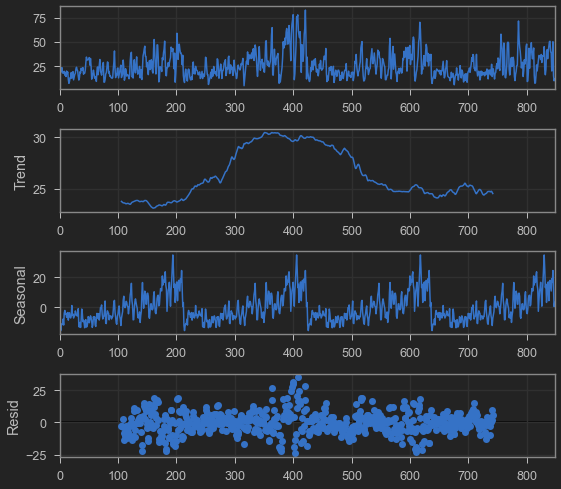

In [37]:
resultado = seasonal_decompose(serie_completa,period=212)
resultado.plot();

# Etapa 4: Teste de estacionariedade

Resultados do teste Dickey Fuller:
Teste estatístico                -4.481090
p-value                           0.000213
#Lags Usados                     10.000000
Número de observações usadas    838.000000
Valores críticos (1%)            -3.438177
Valores críticos (5%)            -2.864995
Valores críticos (10%)           -2.568610
dtype: float64


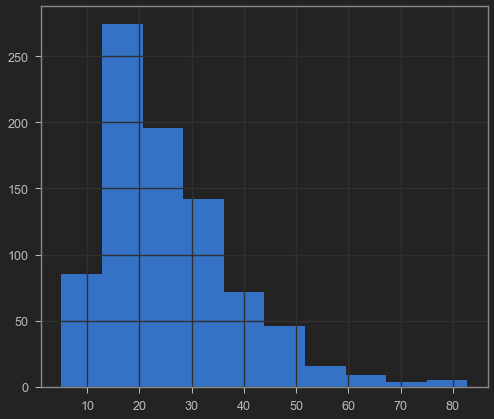

In [38]:
p_value = teste_estacionariedade(serie_completa)
serie_completa.hist()

# Etapa 5: Autocorrelação para verificar a periodicidade e sazonalidade da série

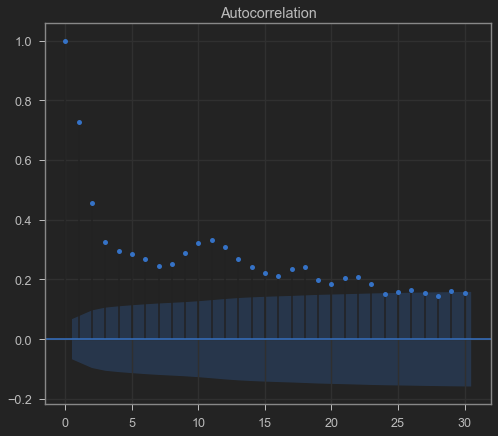

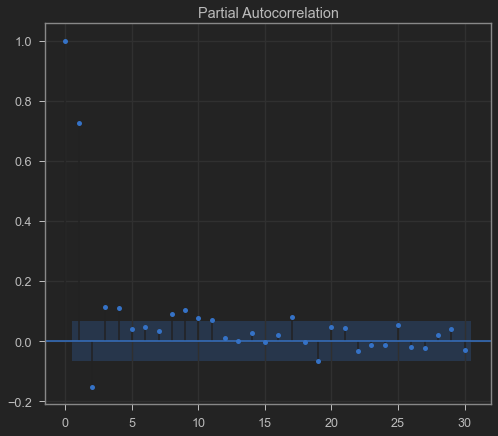

In [39]:
plot_acf(serie_completa);
plot_pacf(serie_completa);

# Etapa 6: Verificando variação nos dados - velocidade de mudança

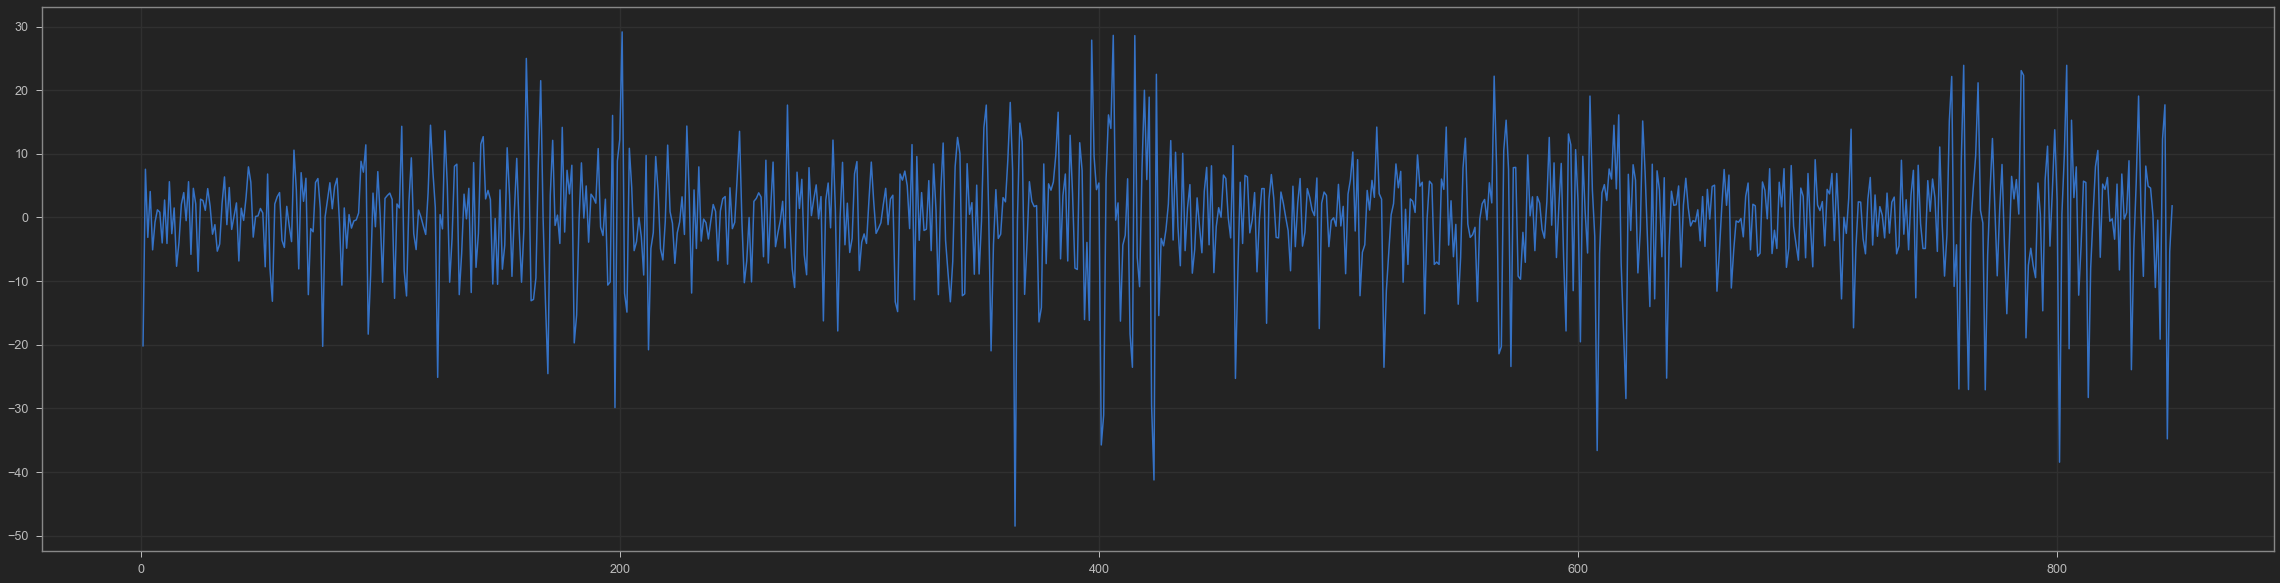

In [40]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa.diff())

# Etapa 7: Verificando variação nos dados - aceleração de mudança

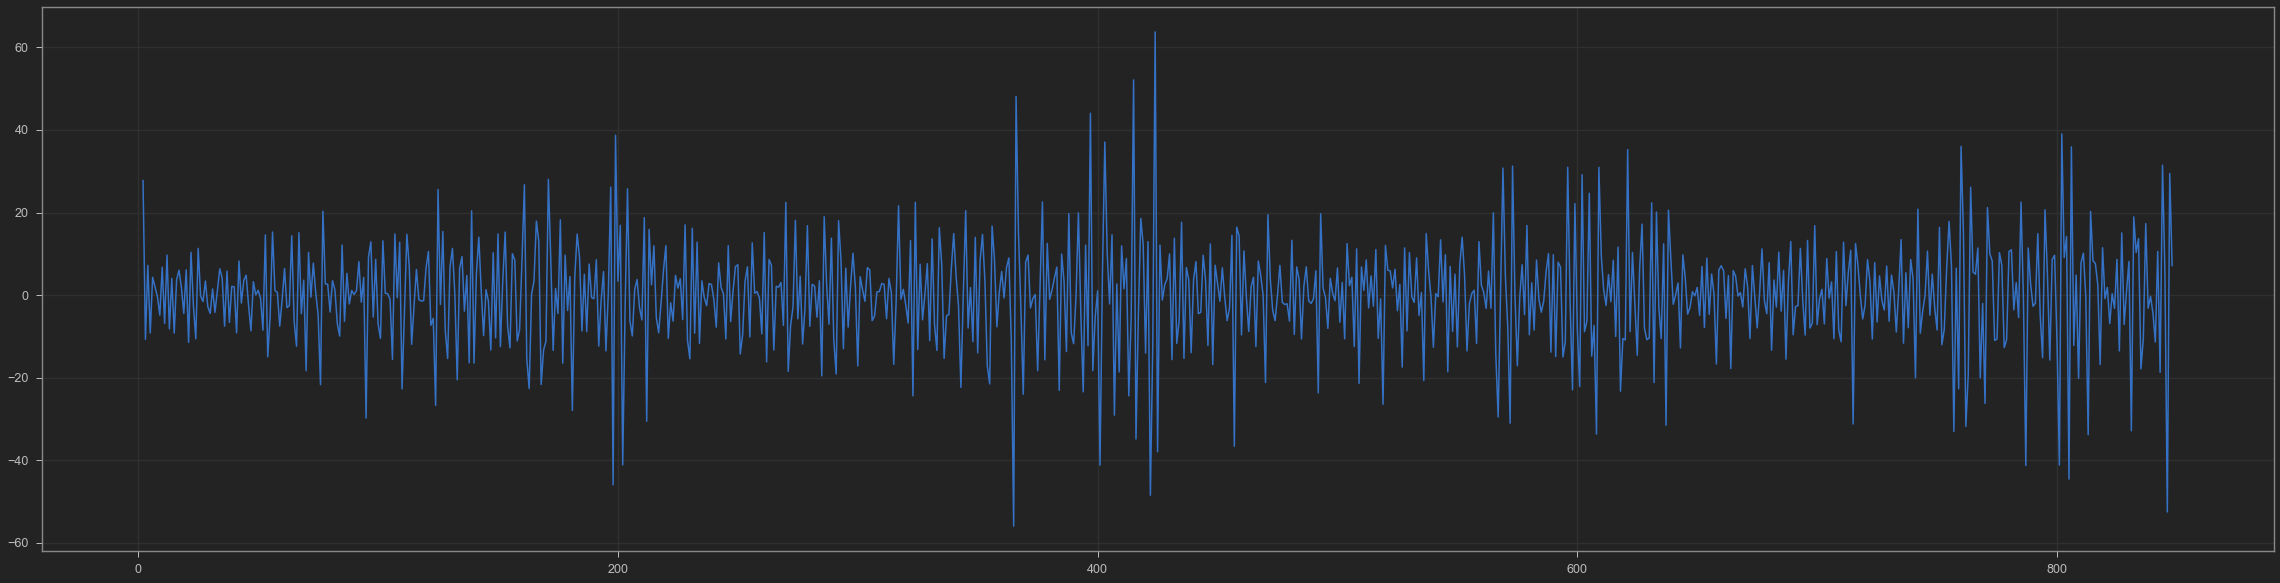

In [41]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa.diff().diff())

# Etapa 7: Autocorrelação da série

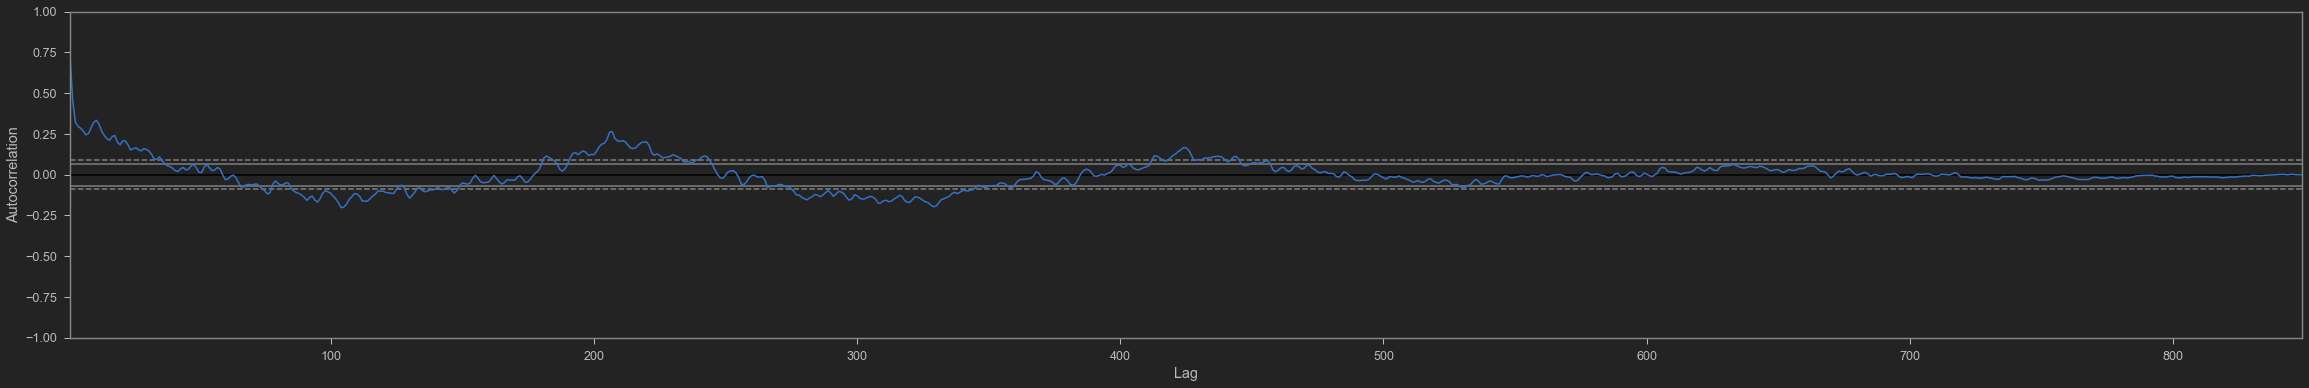

In [42]:
plt.figure(figsize=(40,6))
autocorrelation_plot(serie_completa)

# Comparação com os dados de 2016

In [43]:
serie_completa_com_2016 = dados_medios_completados_2016
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2018)
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2019)
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2020)
serie_completa_com_2016.reset_index(drop=True,inplace=True)
serie_completa_com_2016

0      18.916667
1      11.000000
2       9.791667
3      20.791667
4      21.541667
         ...    
845    32.541667
846    50.250000
847    15.458333
848    10.125000
849    11.958333
Length: 850, dtype: float64

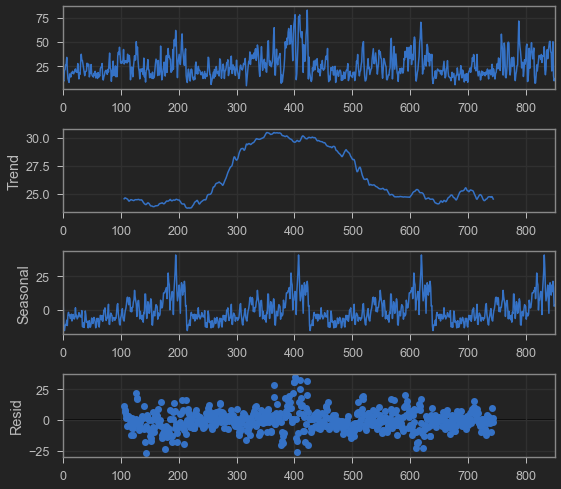

In [44]:
resultado = seasonal_decompose(serie_completa_com_2016,period=212)
resultado.plot();

Resultados do teste Dickey Fuller:
Teste estatístico                -4.510549
p-value                           0.000188
#Lags Usados                     10.000000
Número de observações usadas    839.000000
Valores críticos (1%)            -3.438168
Valores críticos (5%)            -2.864991
Valores críticos (10%)           -2.568608
dtype: float64


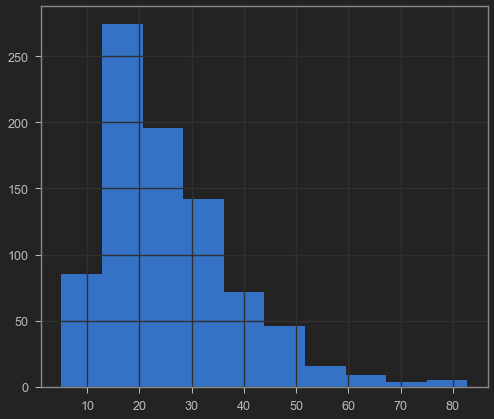

In [45]:
p_value = teste_estacionariedade(serie_completa_com_2016)
serie_completa.hist()

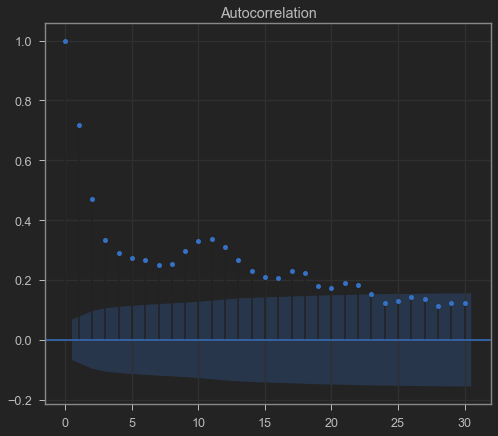

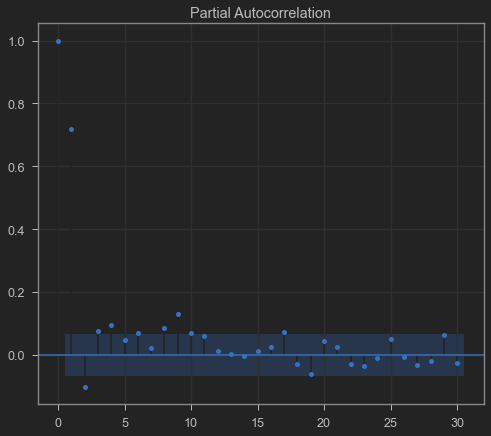

In [46]:
plot_acf(serie_completa_com_2016);
plot_pacf(serie_completa_com_2016);

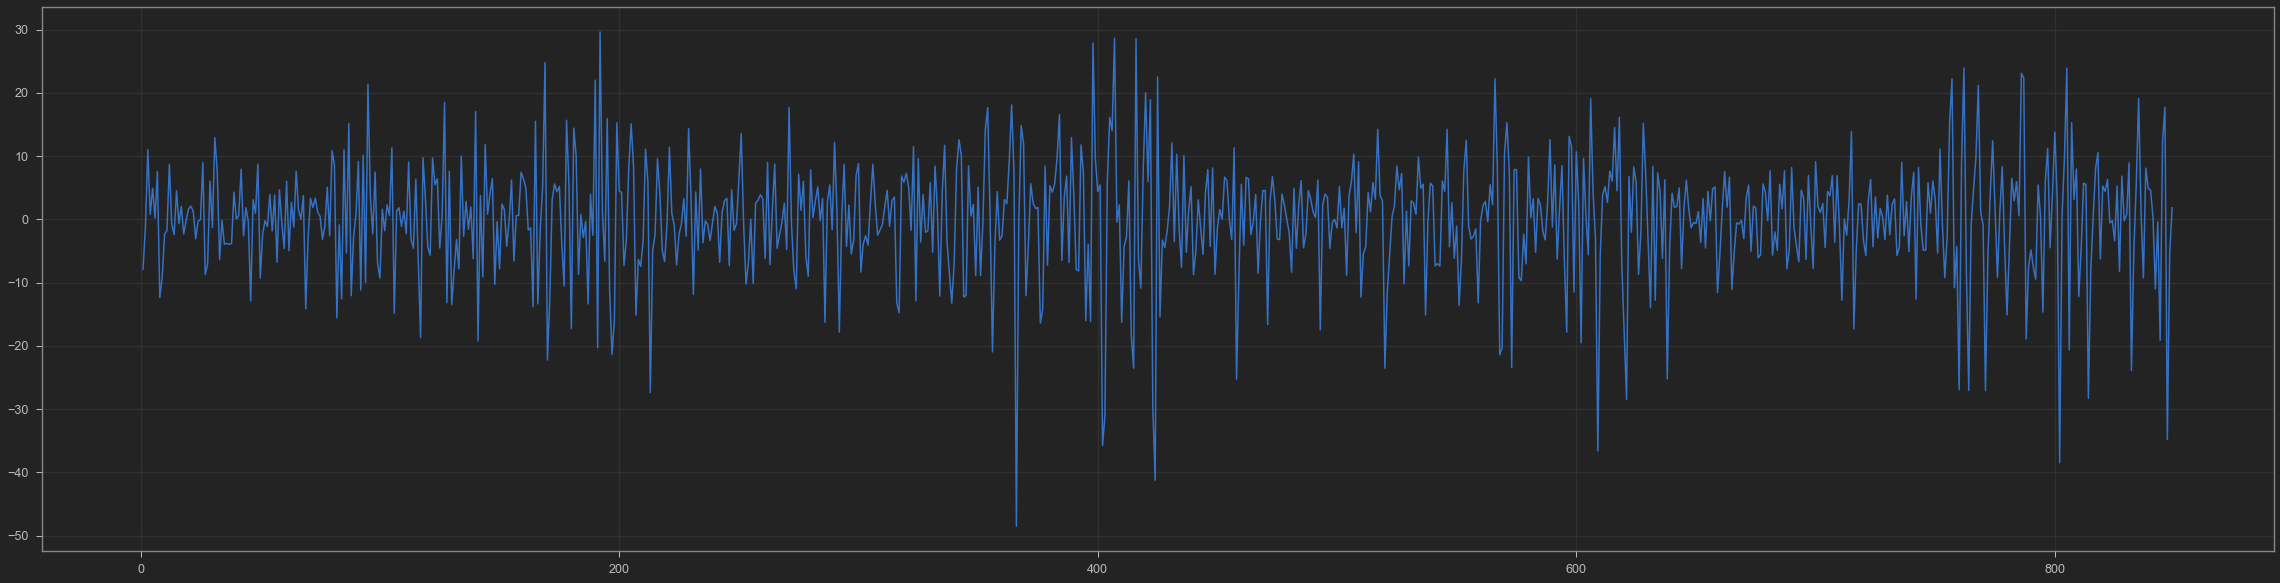

In [47]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_com_2016.diff()) 

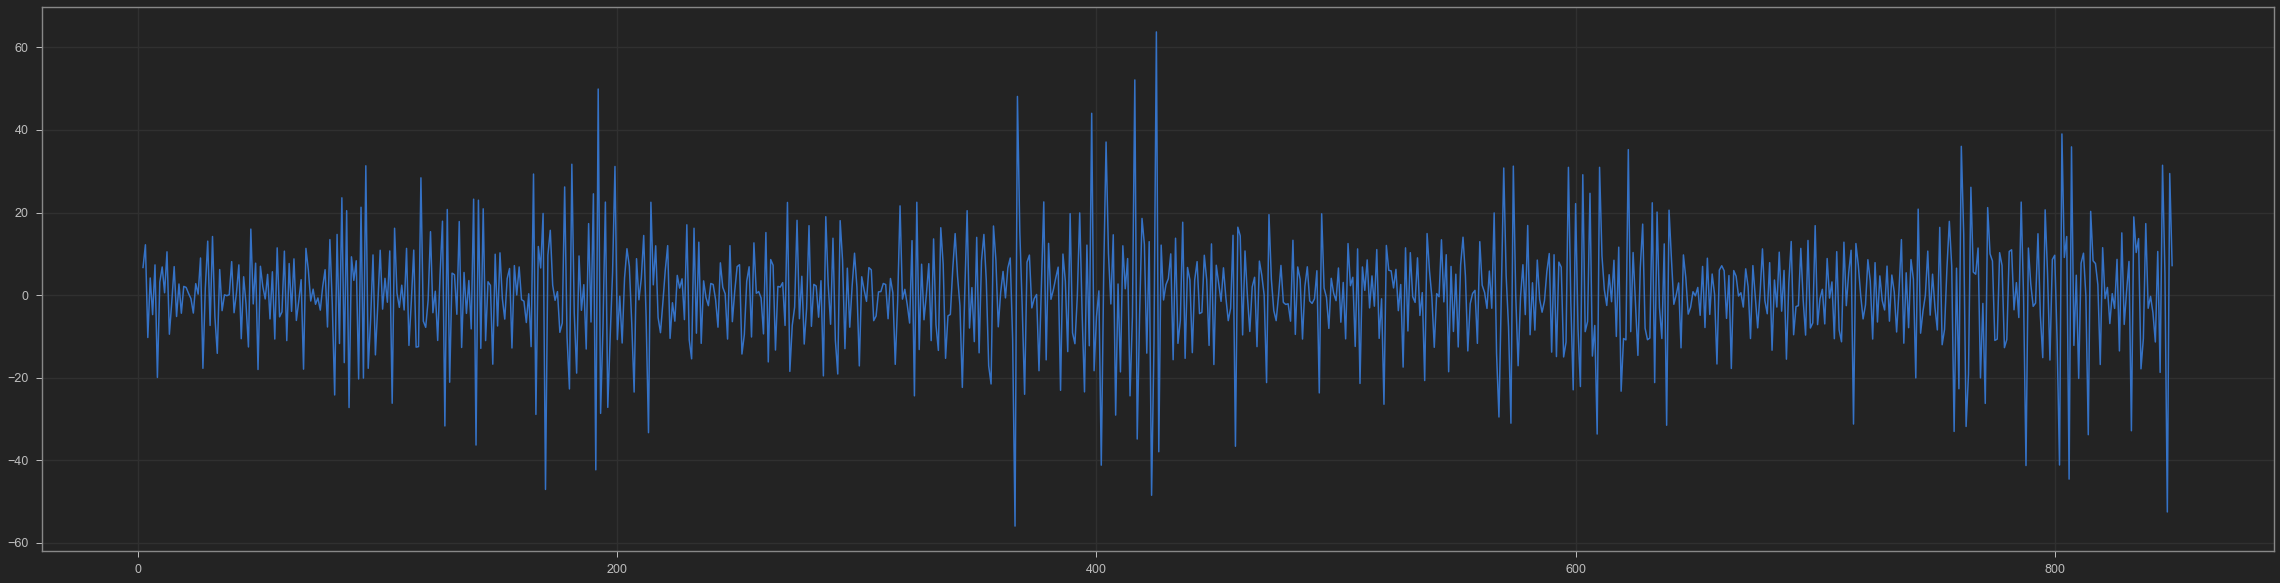

In [48]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_com_2016.diff().diff())

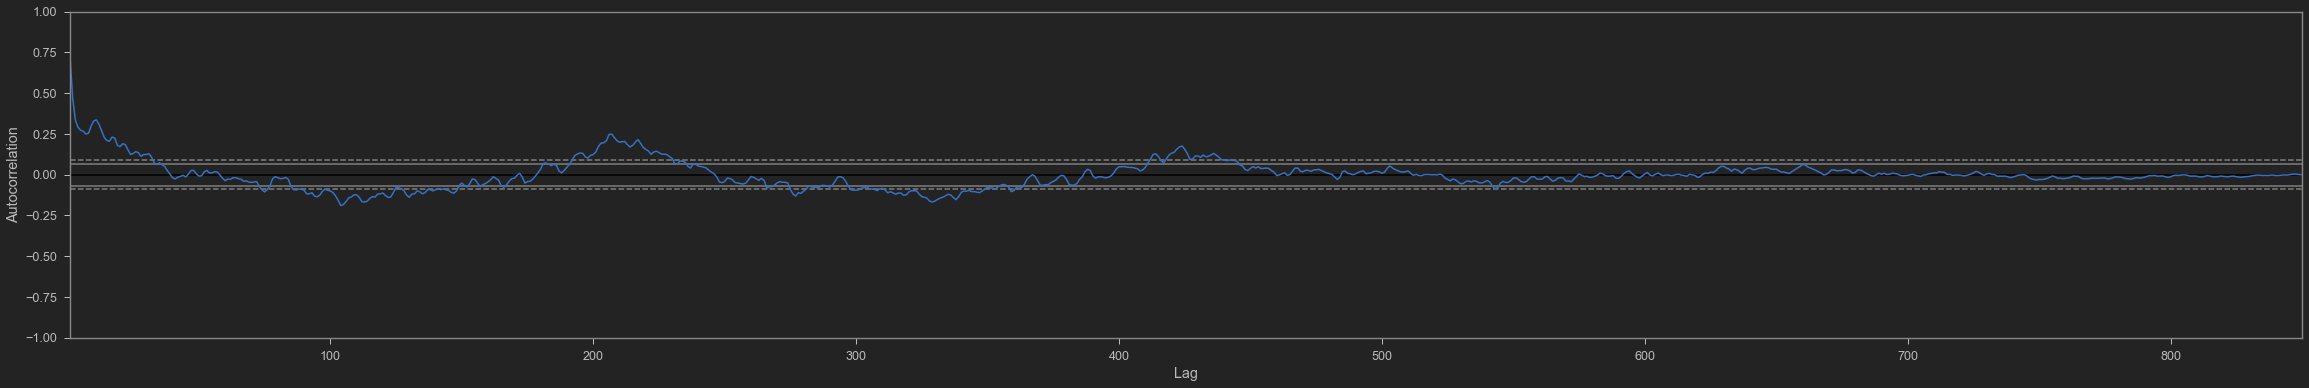

In [49]:
plt.figure(figsize=(40,6))
autocorrelation_plot(serie_completa_com_2016)

# Tratamento com dados suavizados

MAPE:24.98355117548104
MAE:5.452631578947369
MQE:51.707609649122816


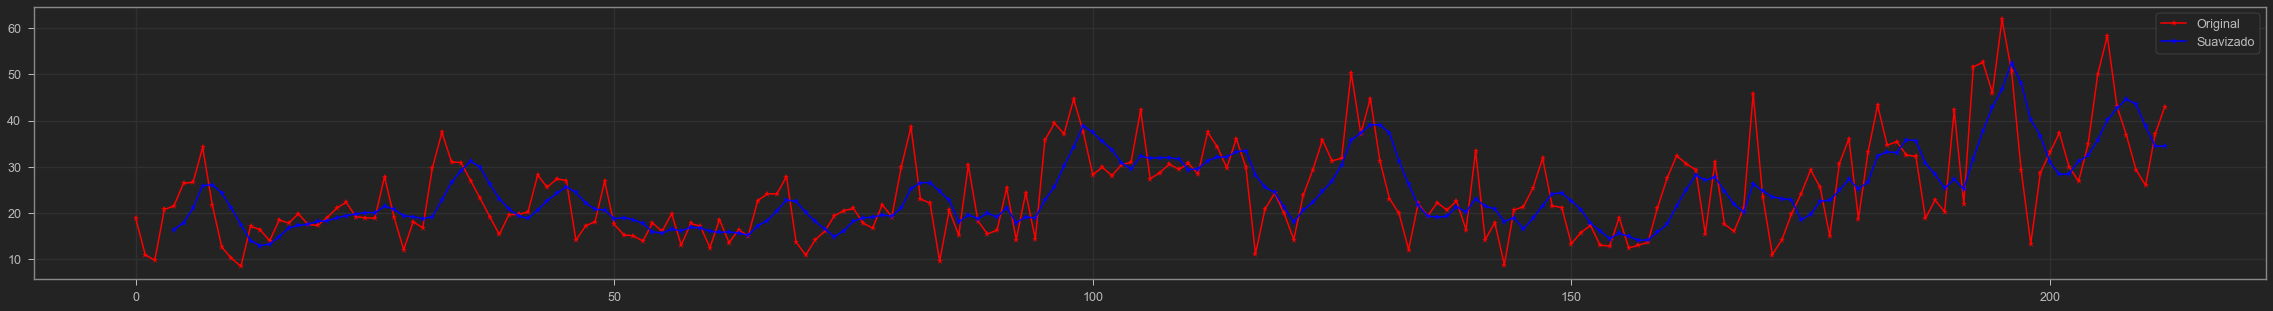

In [50]:
st_2016_suavizado = alisar_serie(dados_medios_completados_2016,p_v_2016)

MAPE:105.5
MAE:105.5
MQE:105.5


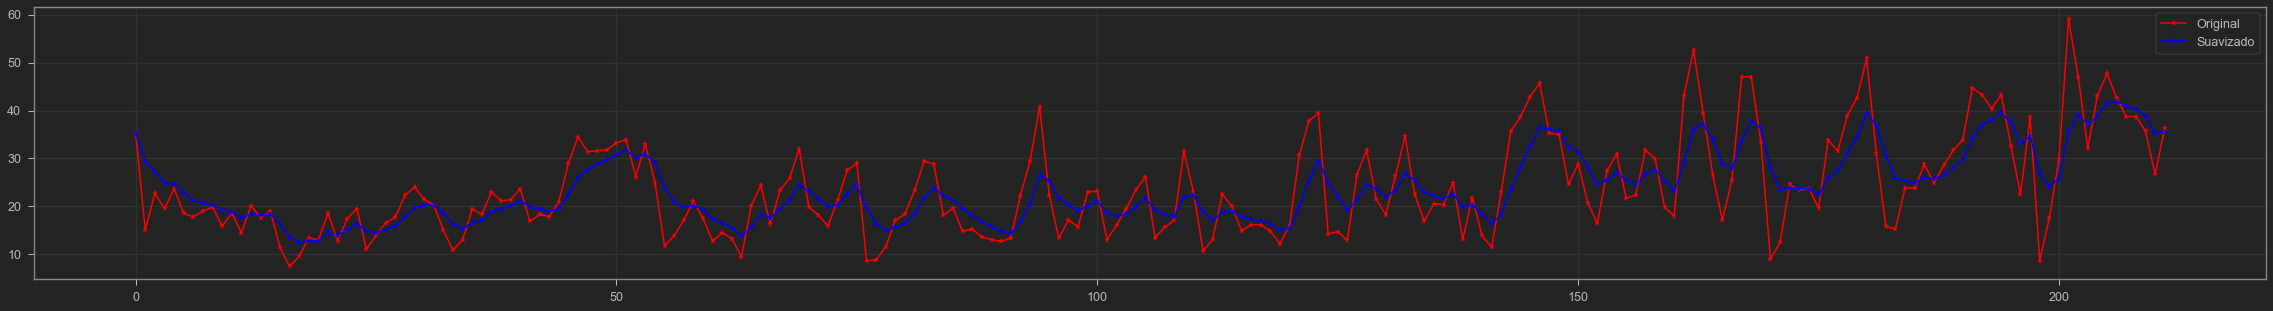

In [51]:
st_2017_suavizado = alisar_serie(dados_medios_completados_2017,p_v_2017)

MAPE:105.5
MAE:105.5
MQE:105.5


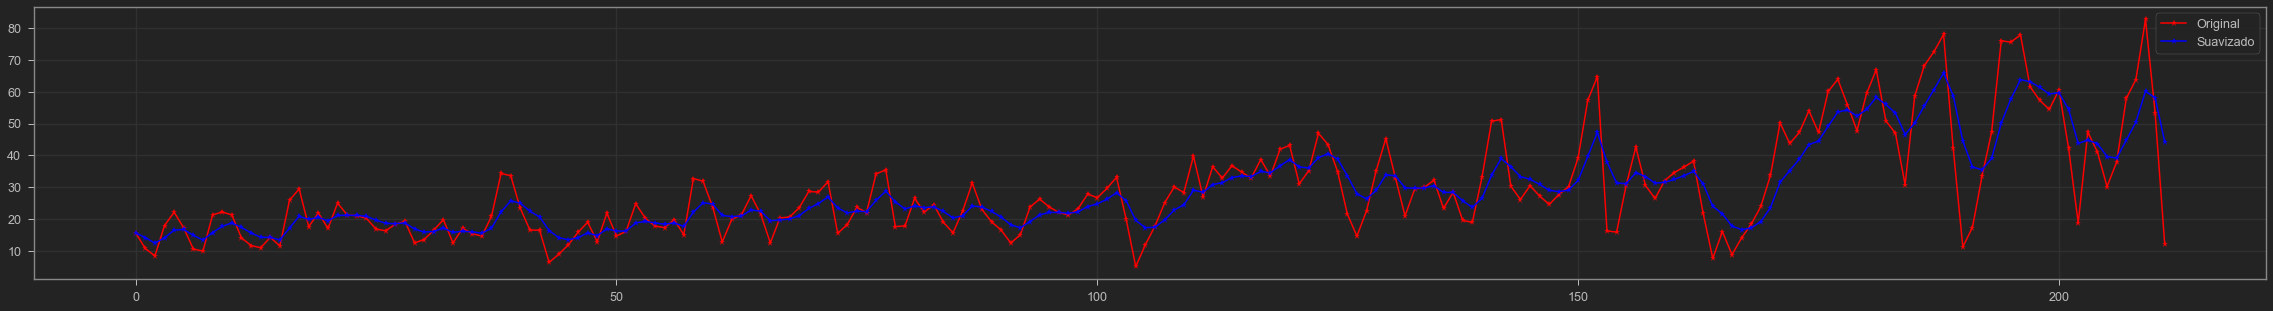

In [52]:
st_2018_suavizado = alisar_serie(dados_medios_completados_2018,p_v_2018)

MAPE:105.5
MAE:105.5
MQE:105.5


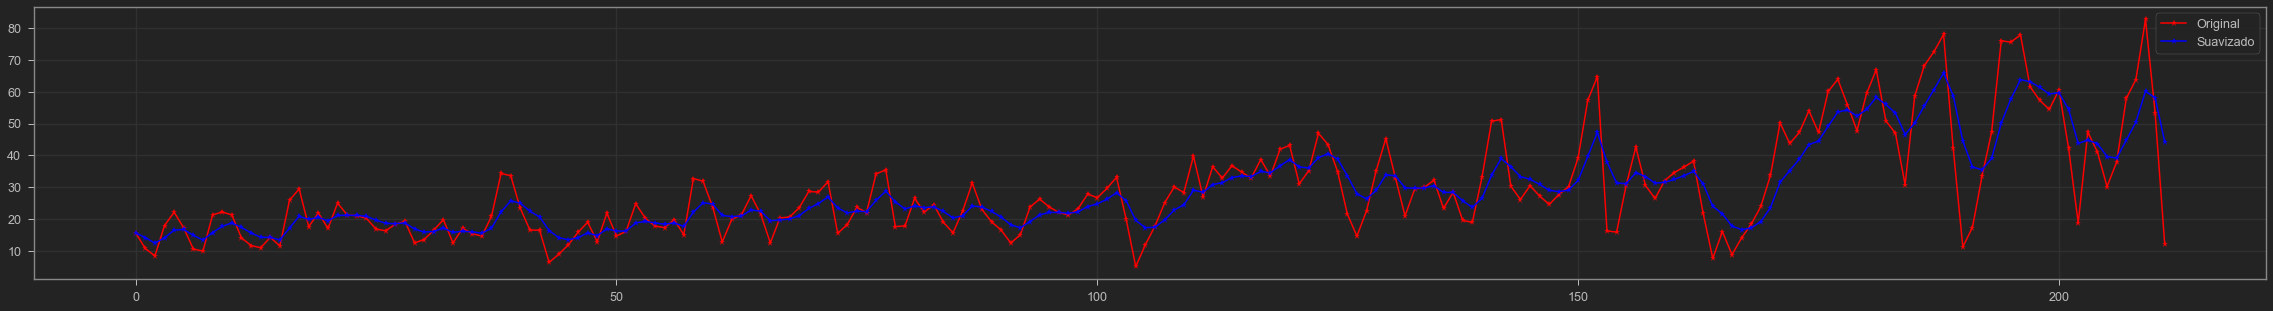

In [53]:
st_2019_suavizado = alisar_serie(dados_medios_completados_2018,p_v_2019)

MAPE:30.67310467395703
MAE:6.265350877192982
MQE:72.11775485114306


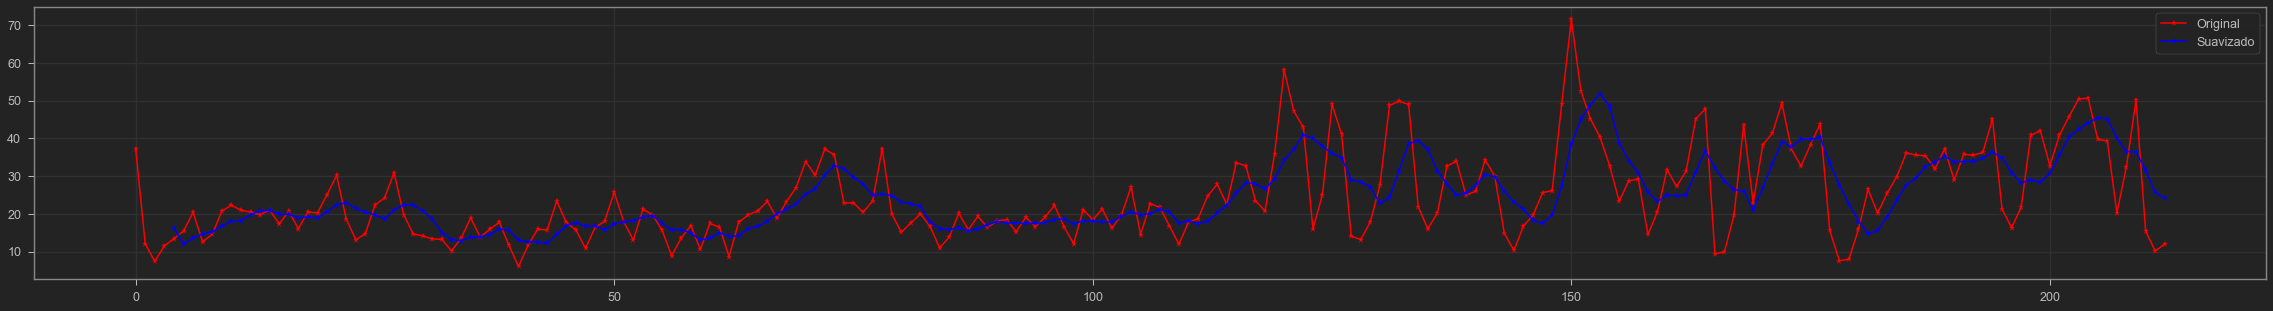

In [54]:
st_2020_suavizado = alisar_serie(dados_medios_completados_2020,p_v_2020)

# Decomposição da série

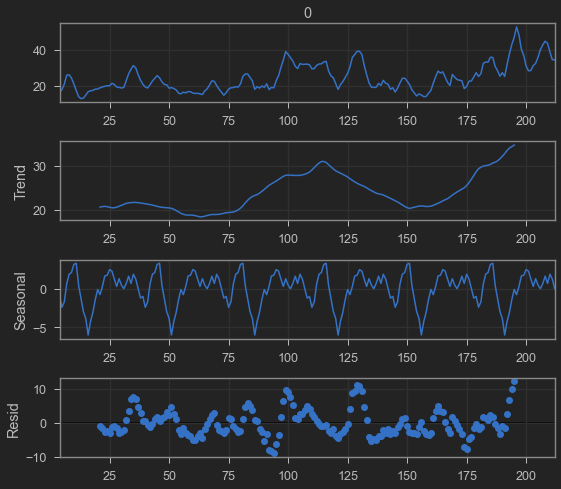

In [55]:
resultado_2016 = seasonal_decompose(st_2016_suavizado,period=35)
resultado_2016.plot();

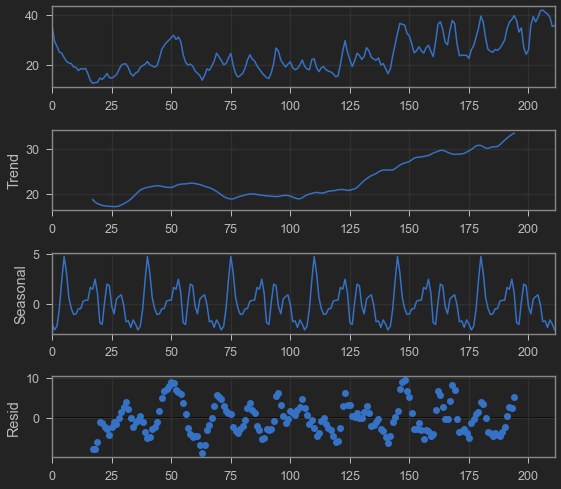

In [56]:
resultado_2017 = seasonal_decompose(st_2017_suavizado,period=35)
resultado_2017.plot();

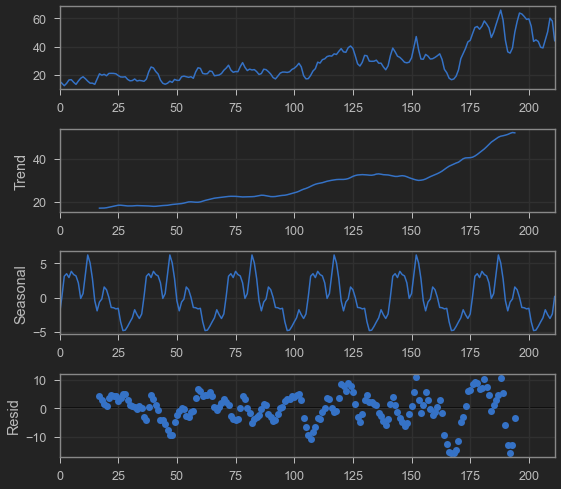

In [57]:
resultado_2018 = seasonal_decompose(st_2018_suavizado,period=35)
resultado_2018.plot();

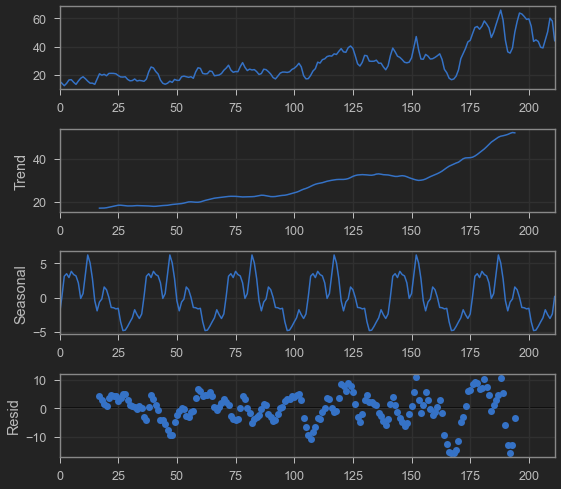

In [58]:
resultado_2019 = seasonal_decompose(st_2019_suavizado,period=35)
resultado_2019.plot();

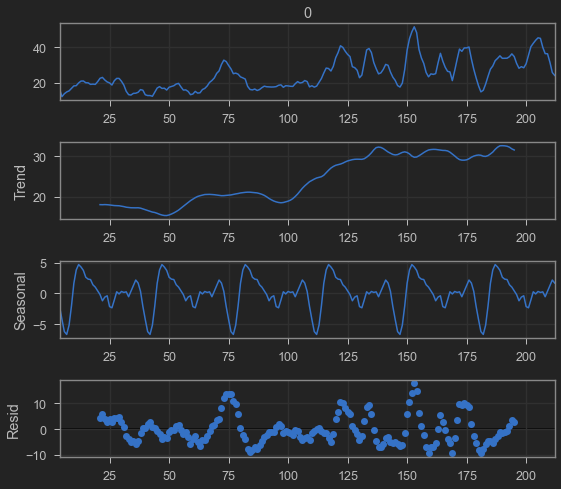

In [59]:
resultado_2020 = seasonal_decompose(st_2020_suavizado,period=35)
resultado_2020.plot();

# Autocorrelação para verificar a periodicidade e sazonalidade da série

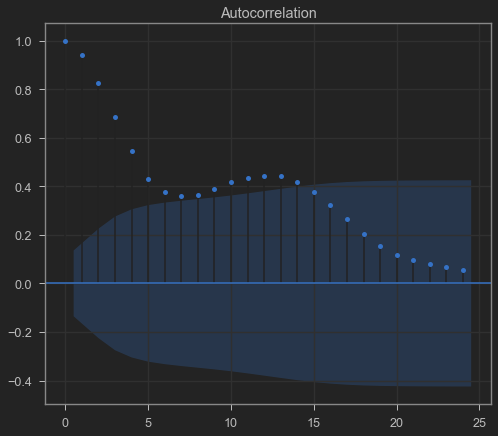

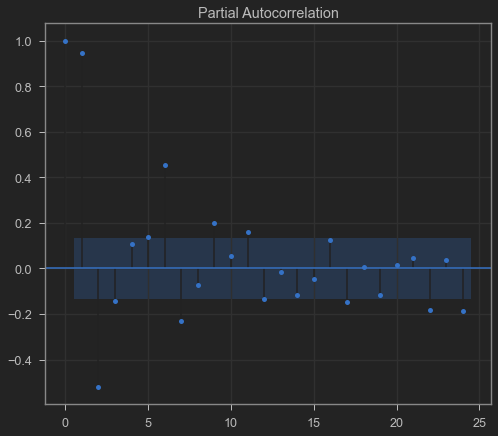

In [60]:
plot_acf(st_2016_suavizado);
plot_pacf(st_2016_suavizado);

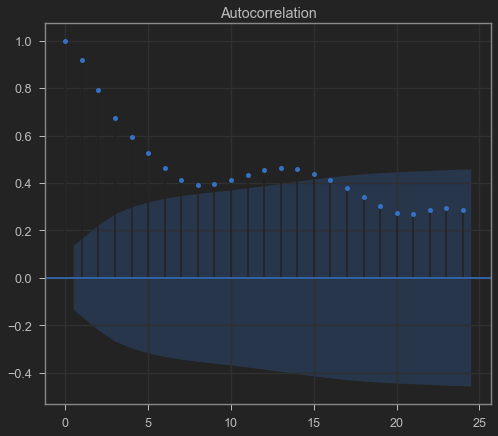

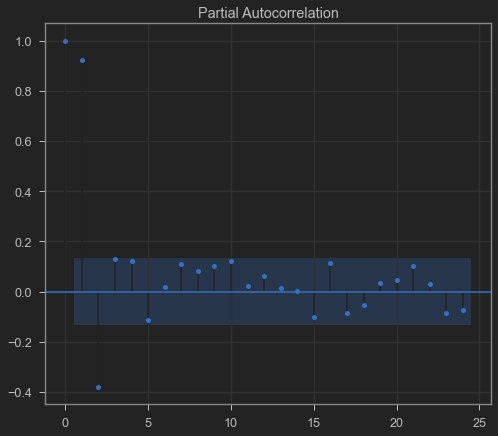

In [61]:
plot_acf(st_2017_suavizado);
plot_pacf(st_2017_suavizado);

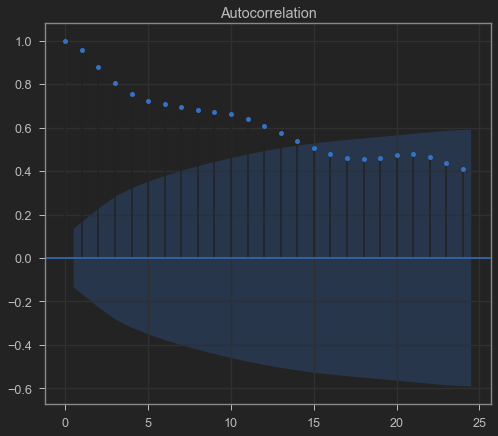

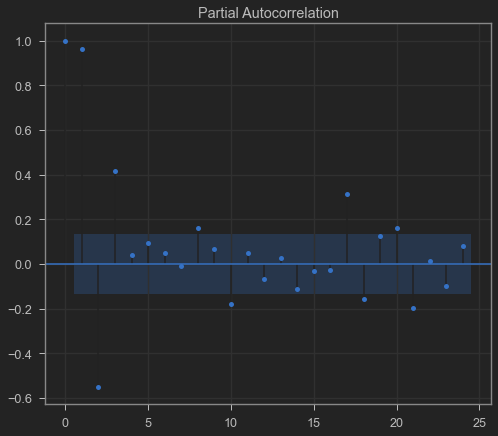

In [62]:
plot_acf(st_2018_suavizado);
plot_pacf(st_2018_suavizado);

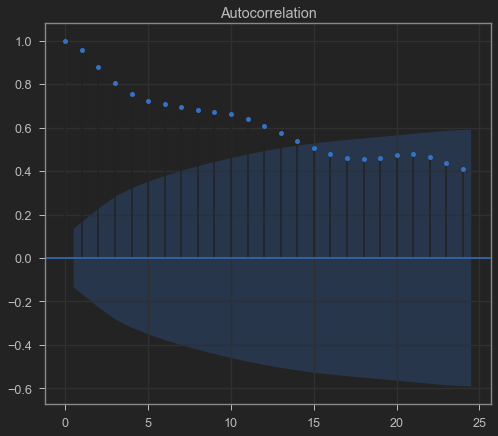

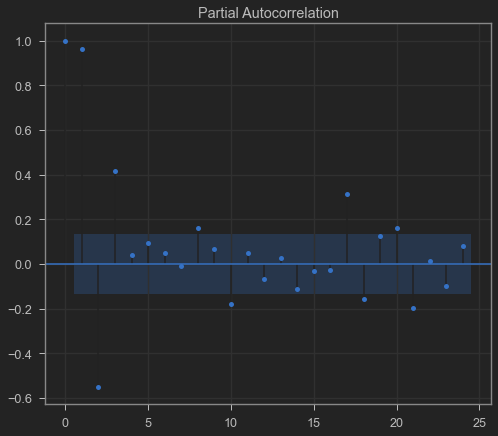

In [63]:
plot_acf(st_2019_suavizado);
plot_pacf(st_2019_suavizado);

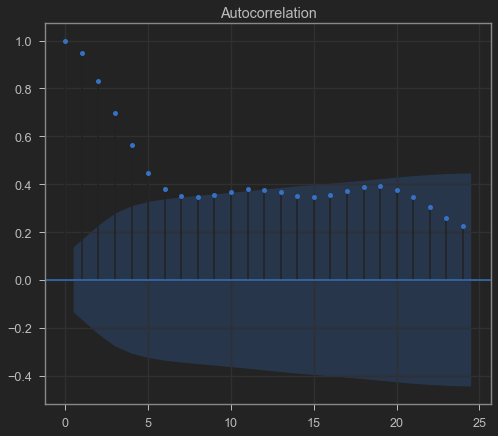

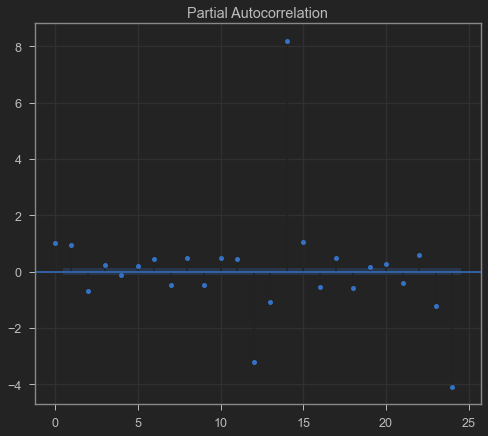

In [64]:
plot_acf(st_2020_suavizado);
plot_pacf(st_2020_suavizado);

# Verificando a variação nos dados - velocidade de mundaça

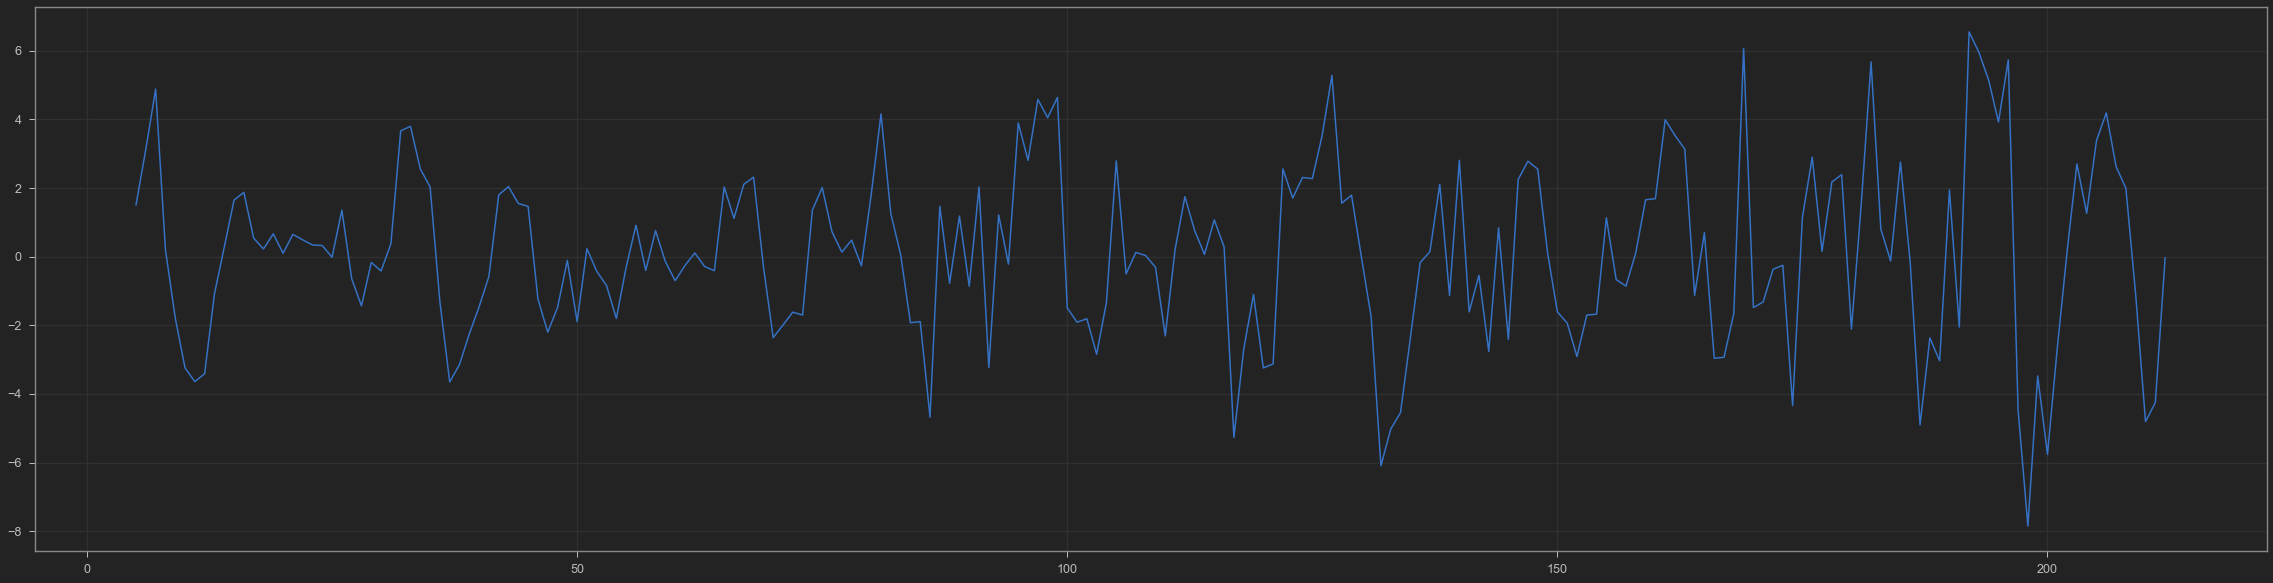

In [65]:
plt.figure(figsize=(40,10))
plt.plot(st_2016_suavizado.diff());

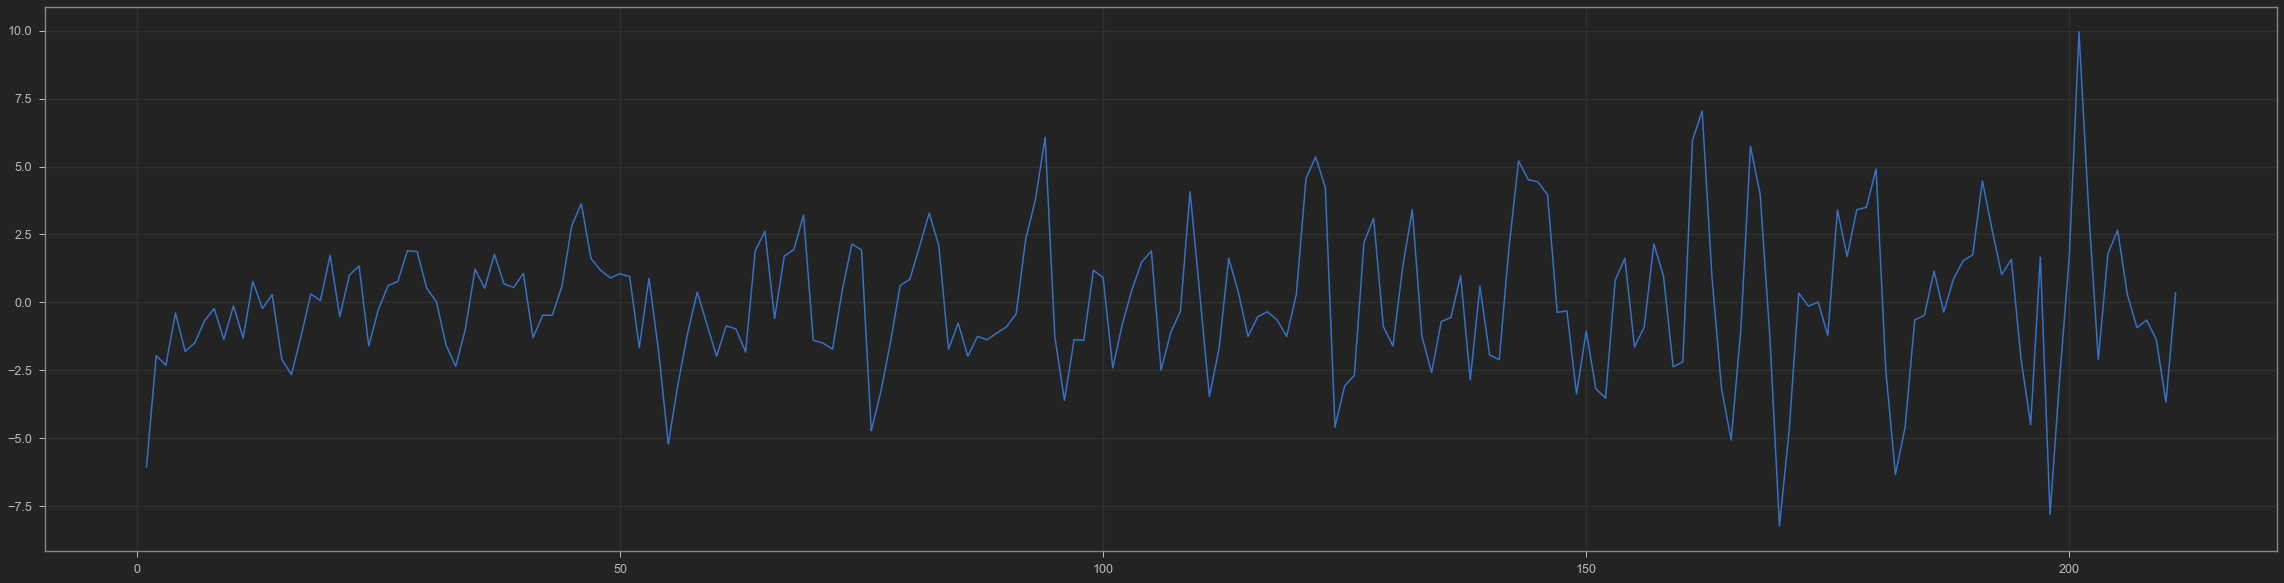

In [66]:
plt.figure(figsize=(40,10))
plt.plot(st_2017_suavizado.diff());

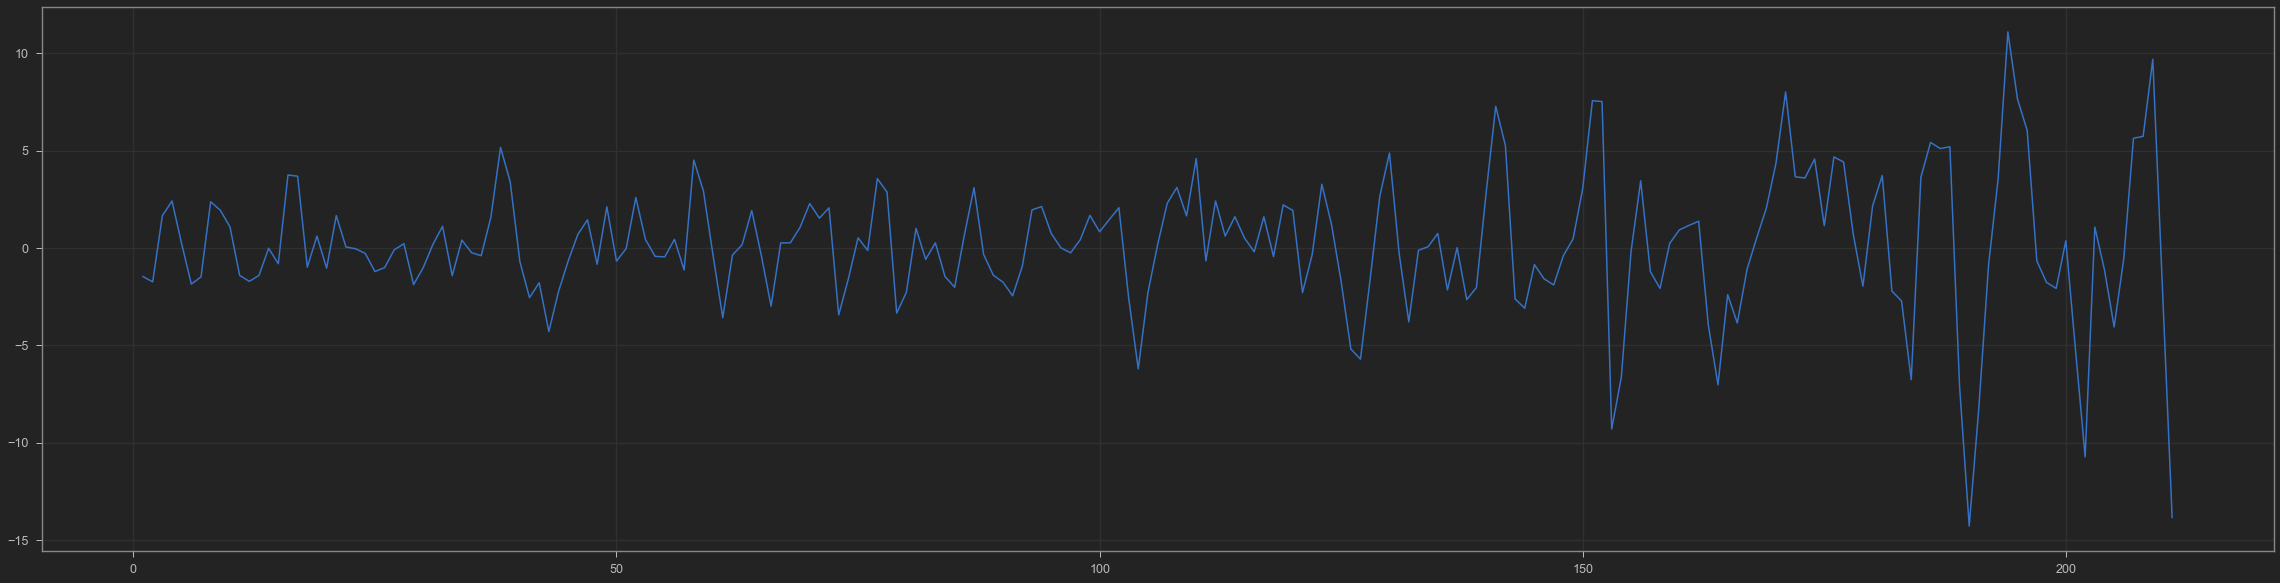

In [67]:
plt.figure(figsize=(40,10))
plt.plot(st_2018_suavizado.diff());

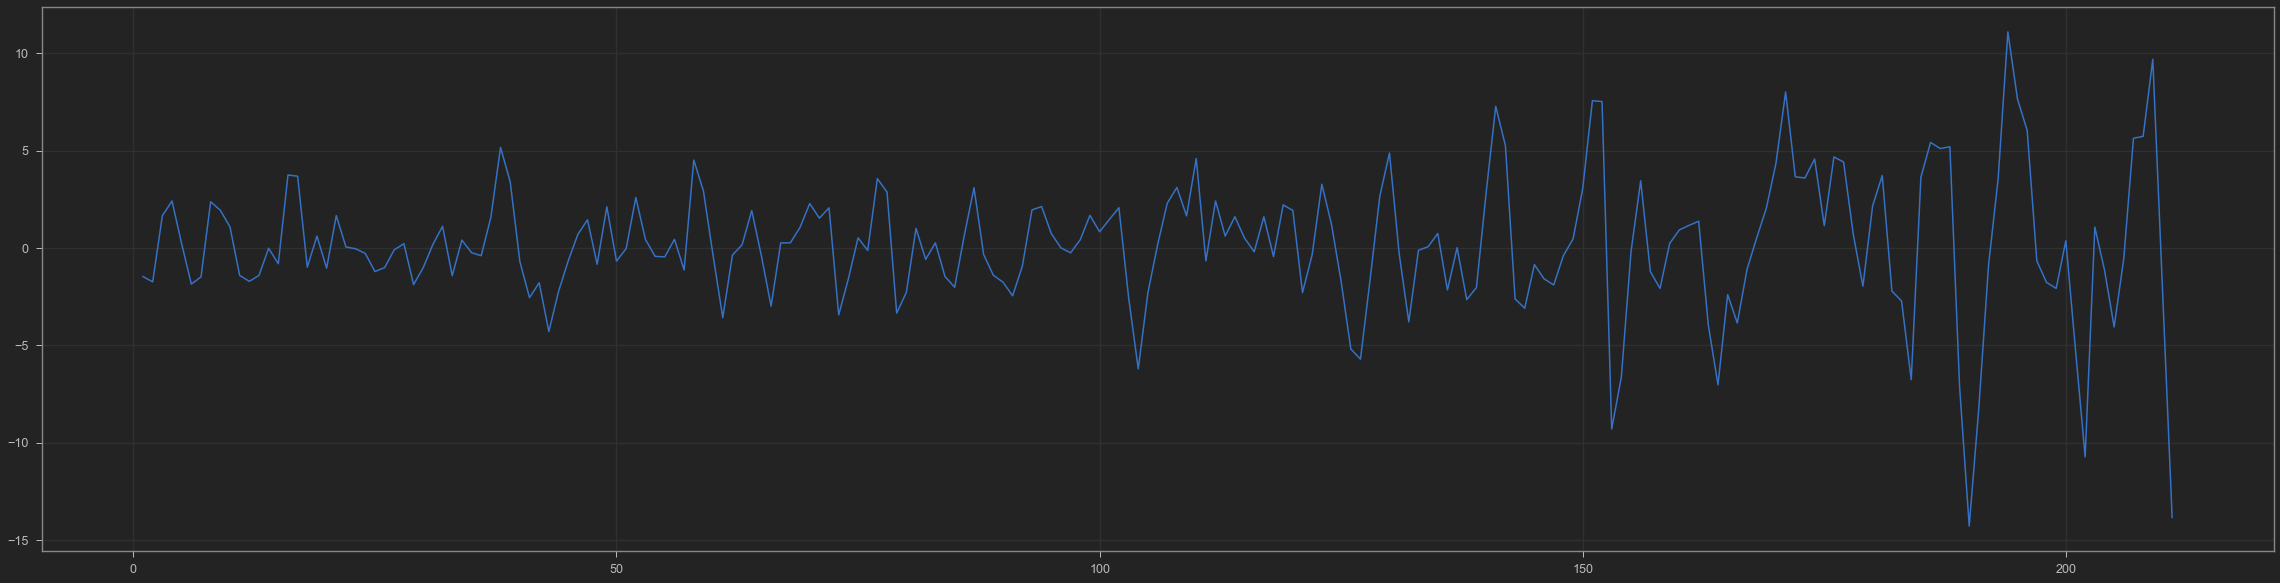

In [68]:
plt.figure(figsize=(40,10))
plt.plot(st_2019_suavizado.diff());

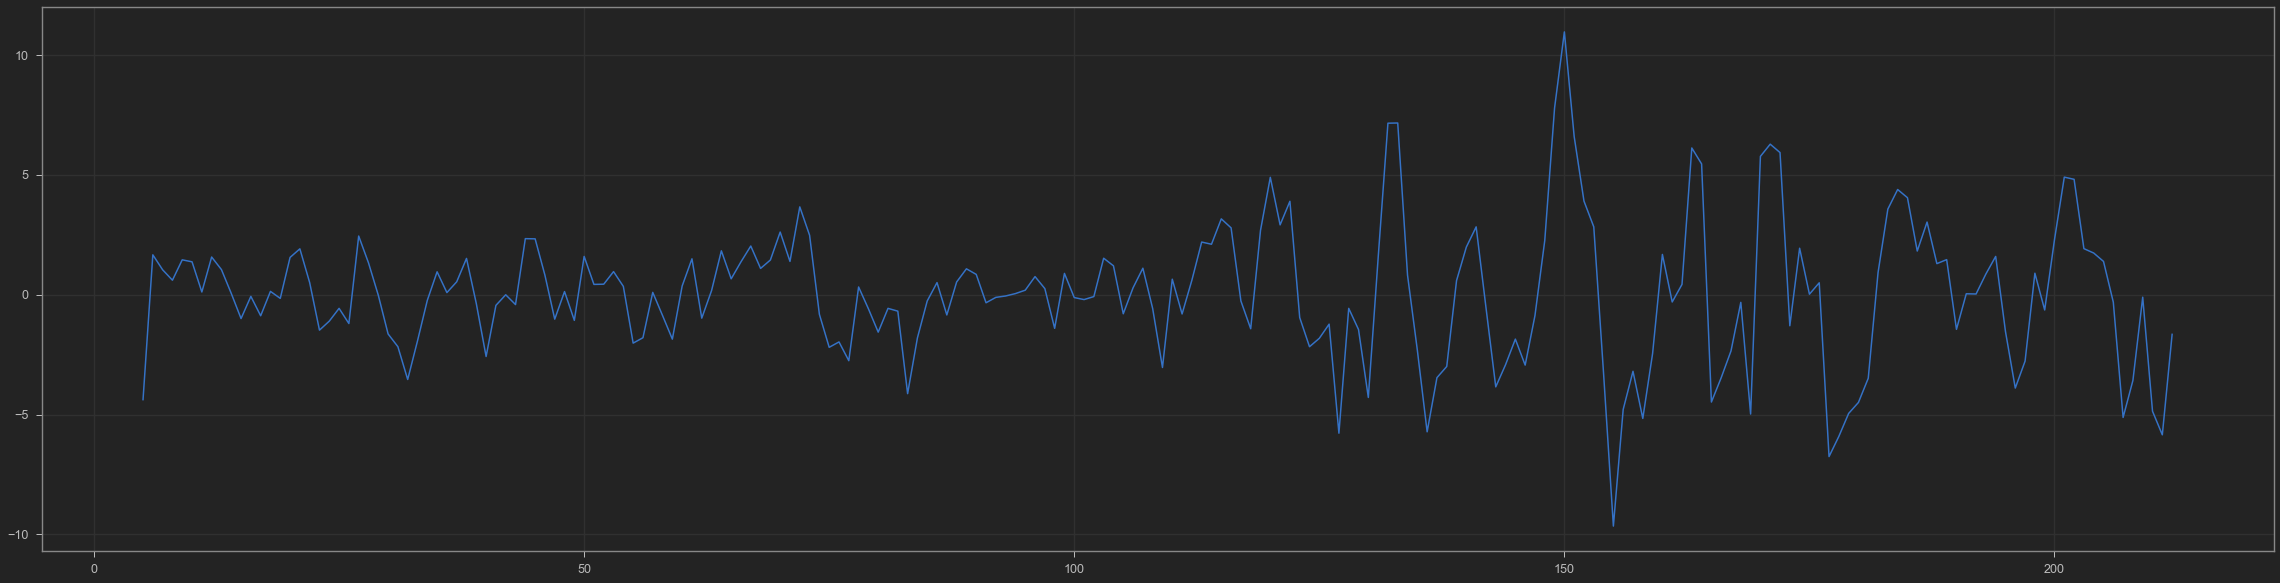

In [69]:
plt.figure(figsize=(40,10))
plt.plot(st_2020_suavizado.diff());

# Verifiacando a variação nos dados - aceleração de mundaça

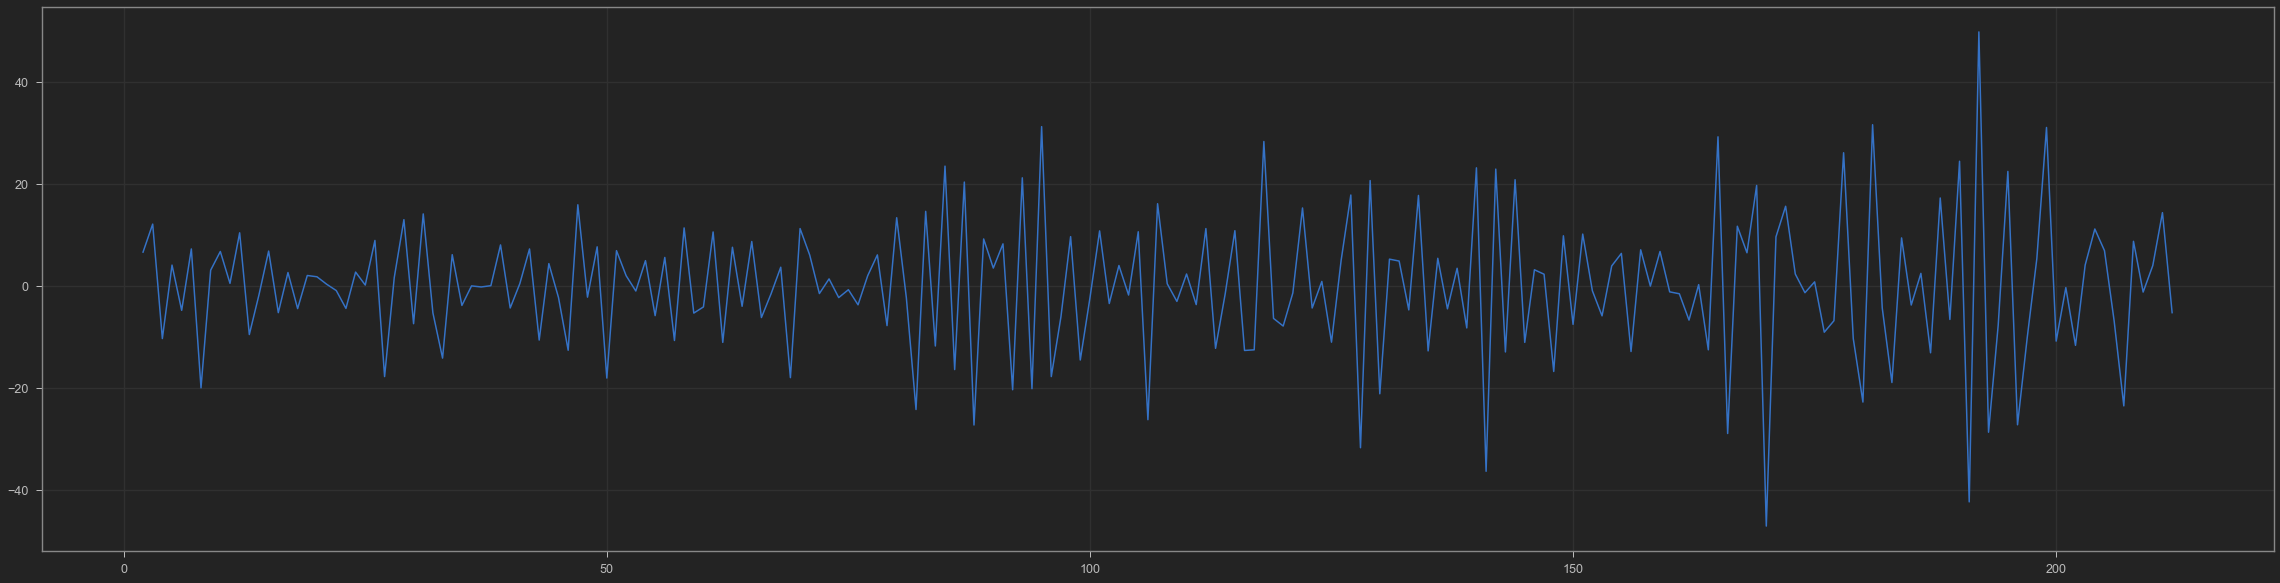

In [70]:
plt.figure(figsize=(40,10))
velocidade_2016 = dados_medios_completados_2016.diff()
plt.plot(velocidade_2016.diff());

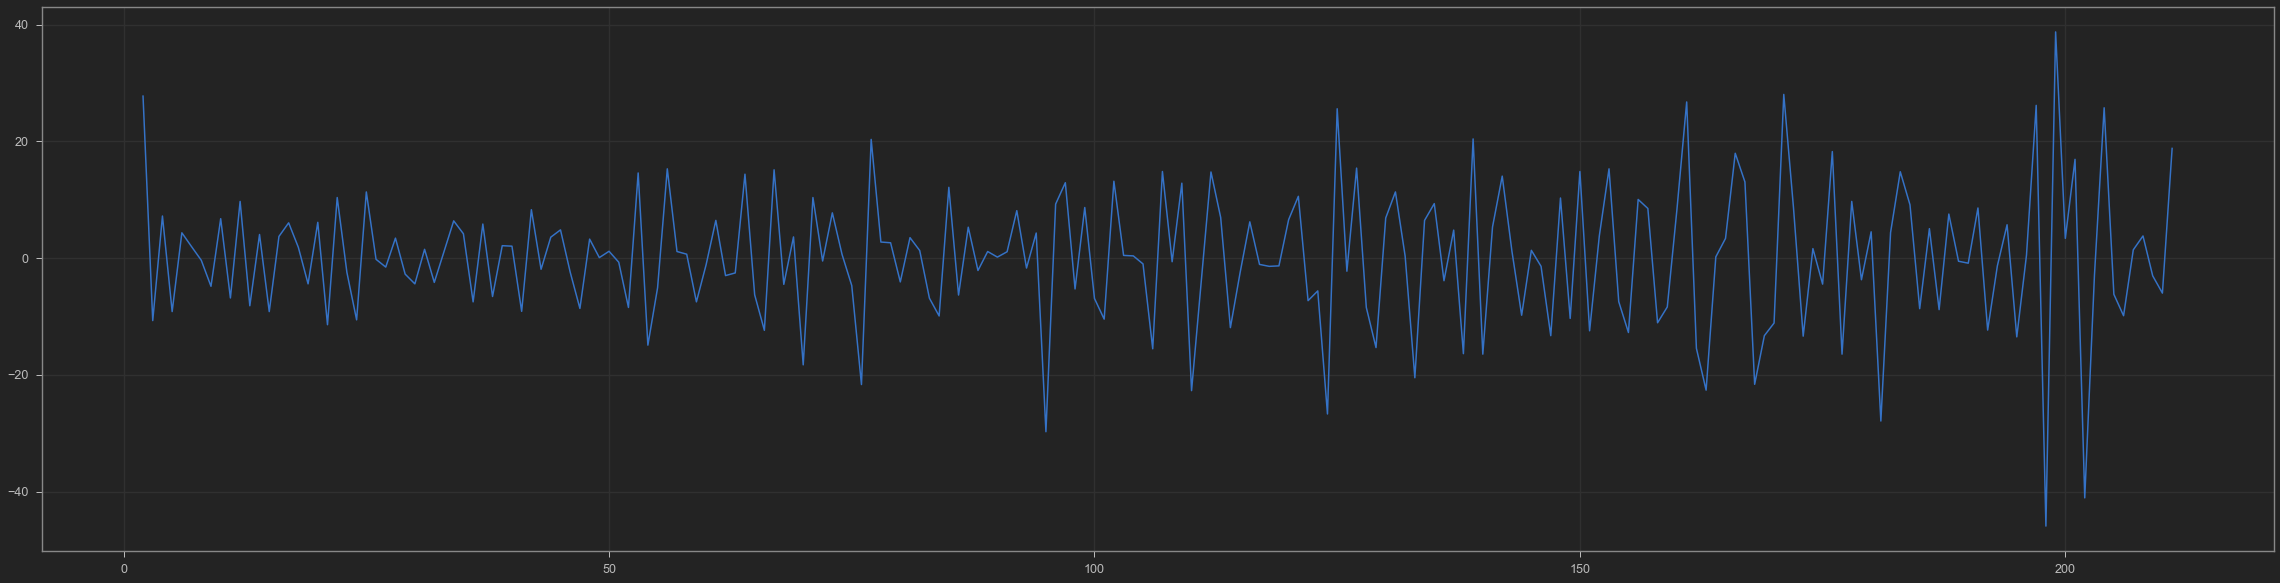

In [71]:
plt.figure(figsize=(40,10))
velocidade_2017 = dados_medios_completados_2017.diff()
plt.plot(velocidade_2017.diff());

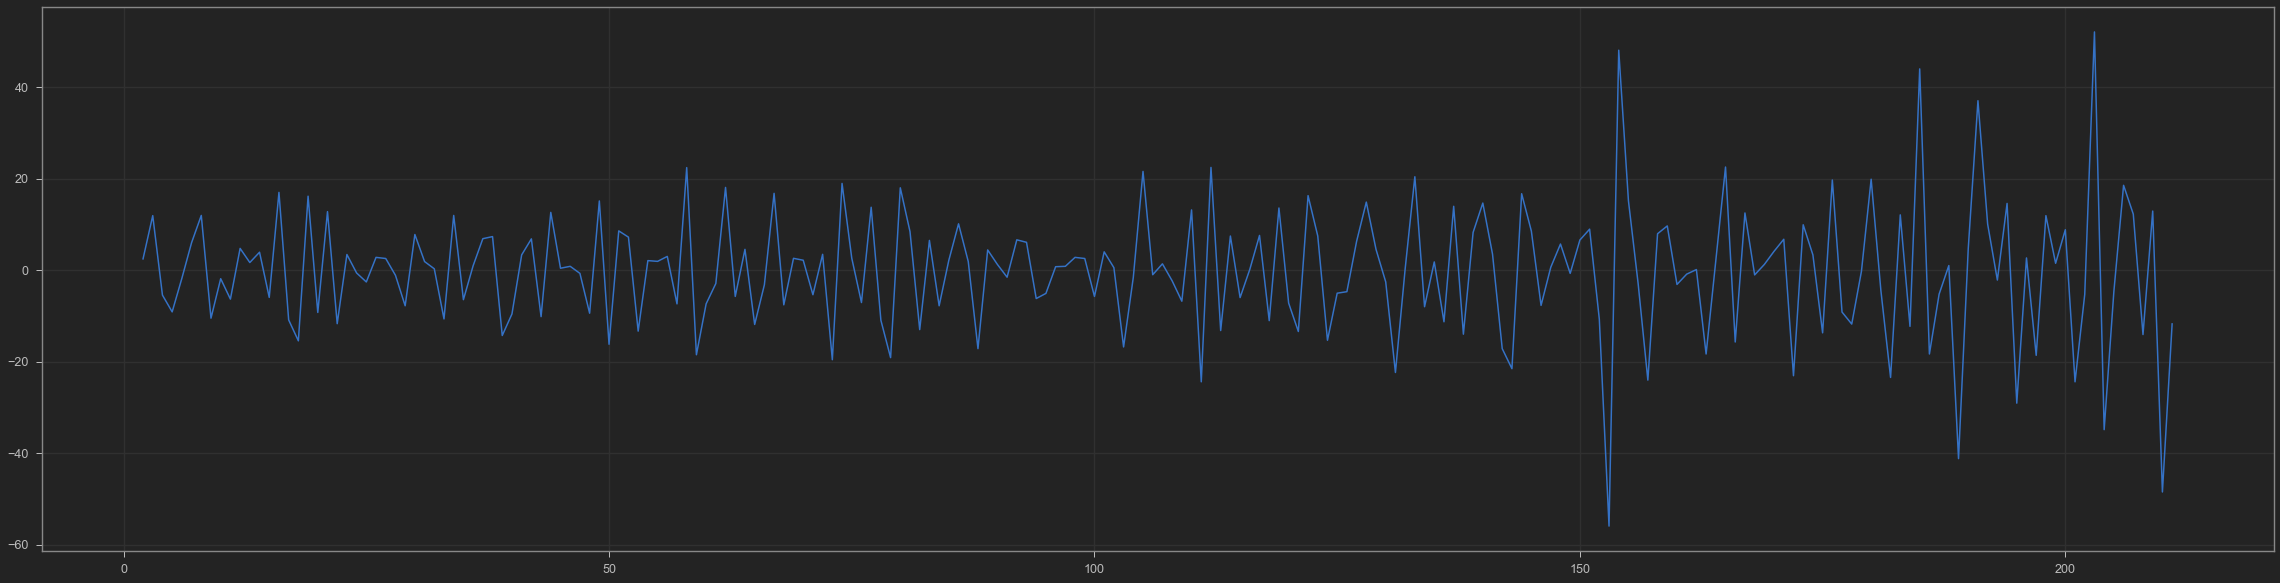

In [72]:
plt.figure(figsize=(40,10))
velocidade_2018 = dados_medios_completados_2018.diff()
plt.plot(velocidade_2018.diff());

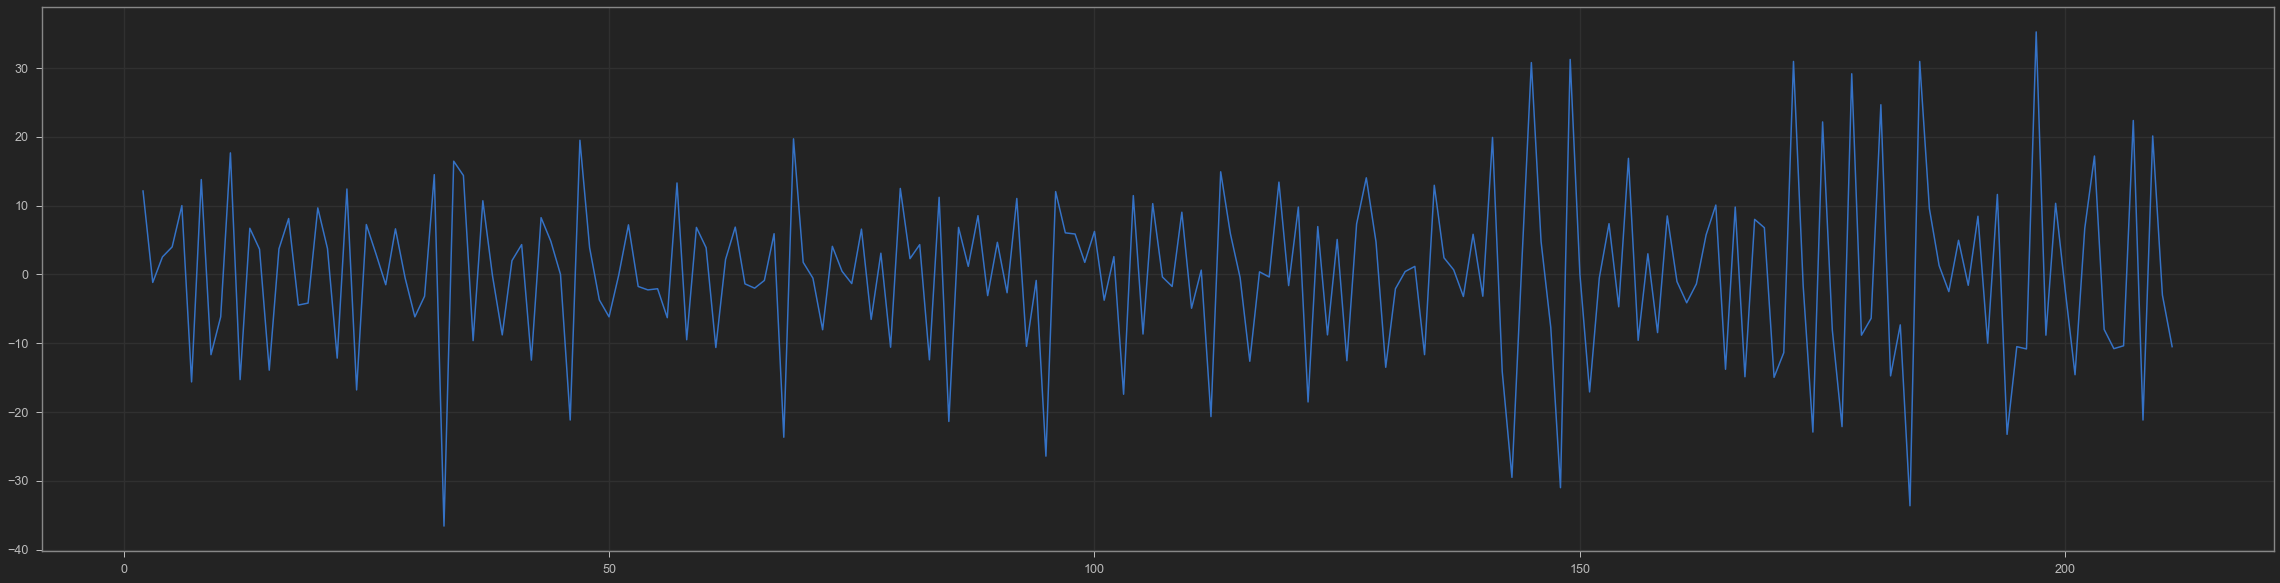

In [73]:
plt.figure(figsize=(40,10))
velocidade_2019 = dados_medios_completados_2019.diff()
plt.plot(velocidade_2019.diff());

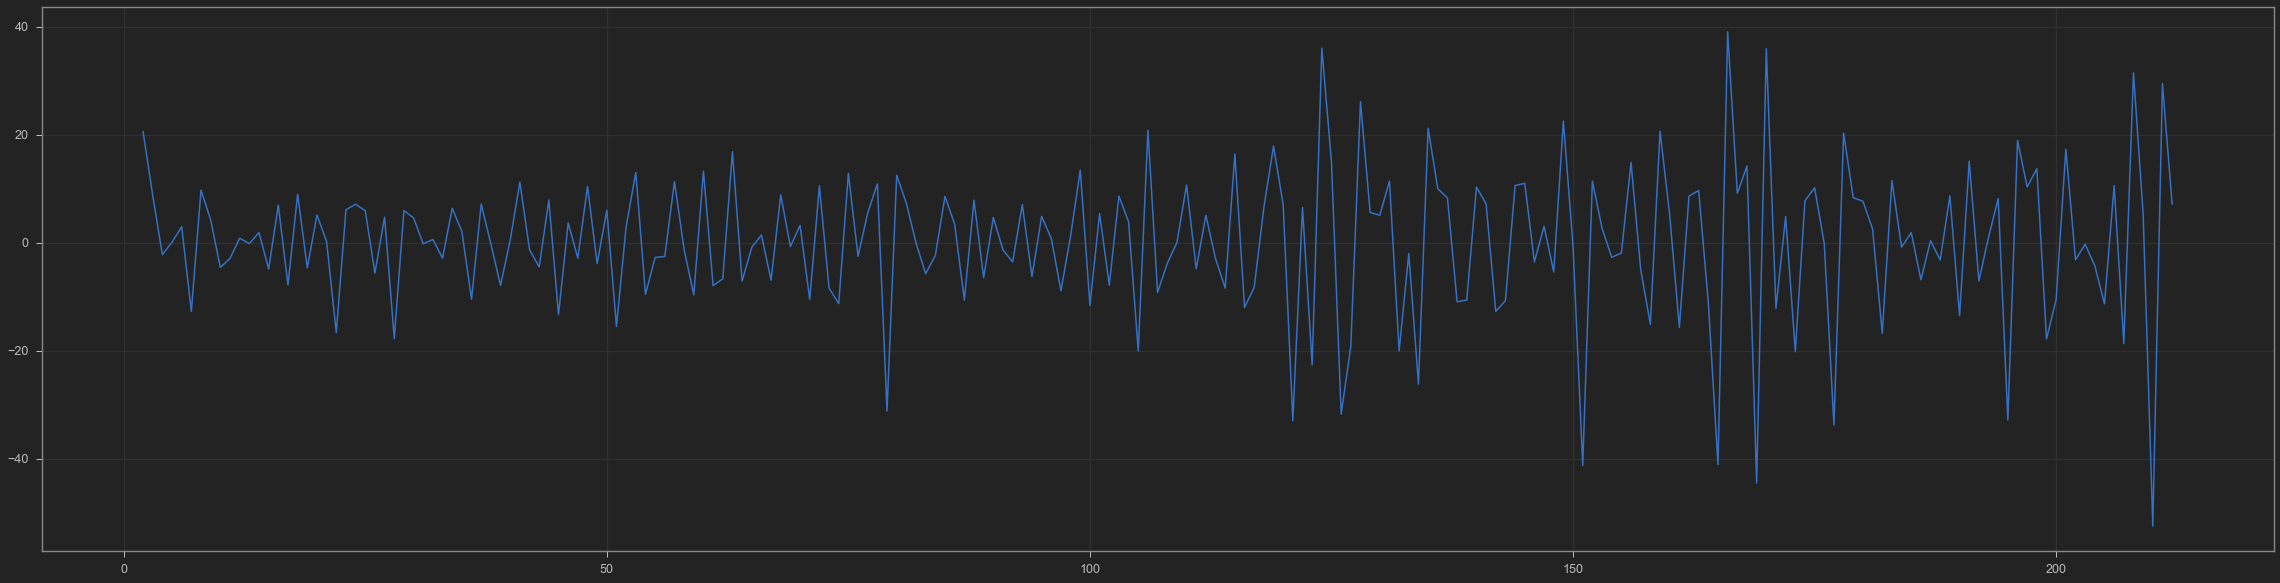

In [74]:
plt.figure(figsize=(40,10))
velocidade_2020 = dados_medios_completados_2020.diff()
plt.plot(velocidade_2020.diff());

# Autocorrelação da série

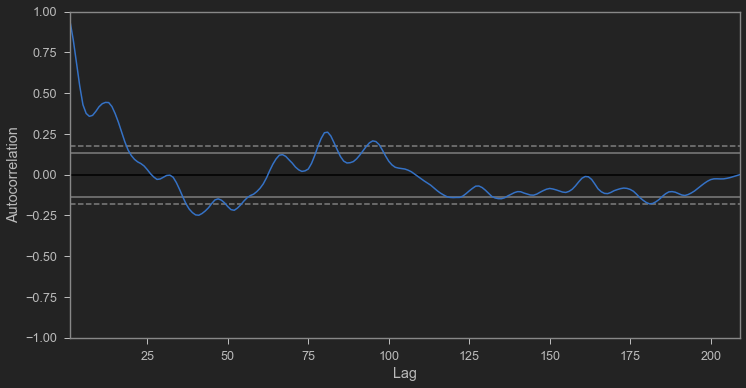

In [75]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2016_suavizado)

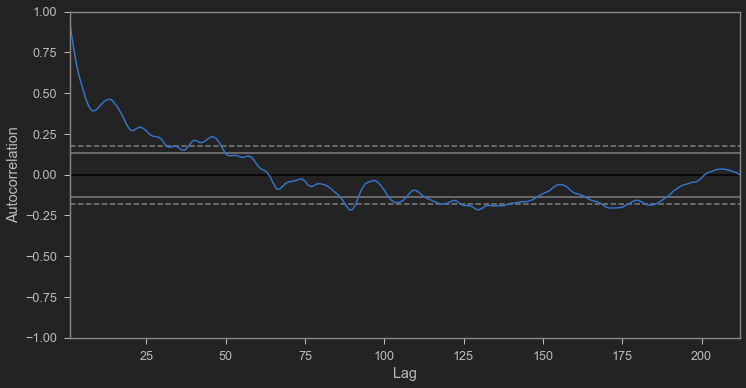

In [76]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2017_suavizado)

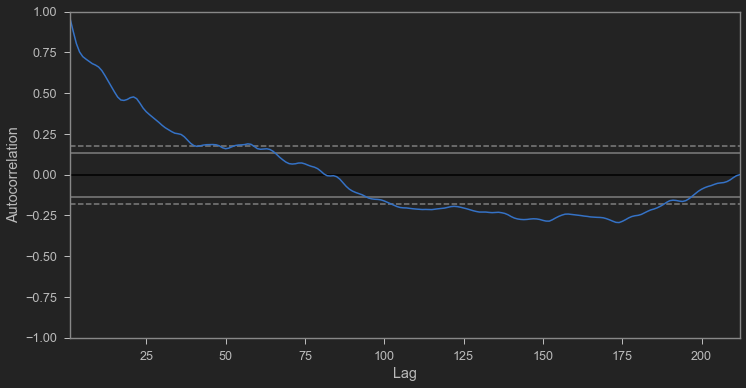

In [77]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2018_suavizado)

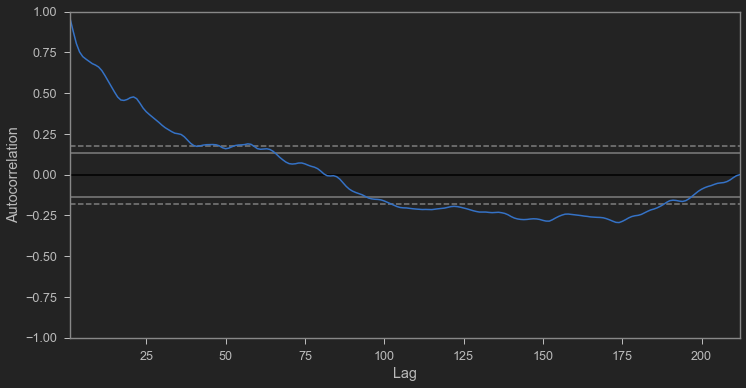

In [78]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2019_suavizado)

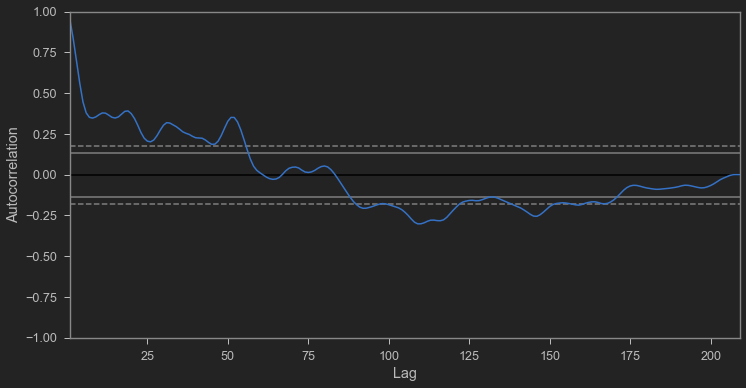

In [79]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2020_suavizado)

# Juntado a base dados suavizada

In [80]:
st_2016_suavizado.dropna(inplace=True)
st_2016_suavizado.reset_index(drop=True,inplace=True)

st_2017_suavizado.dropna(inplace=True)
st_2016_suavizado.reset_index(drop=True,inplace=True)

st_2018_suavizado.dropna(inplace=True)
st_2018_suavizado.reset_index(drop=True,inplace=True)
st_2019_suavizado.dropna(inplace=True)
st_2019_suavizado.reset_index(drop=True,inplace=True)

st_2020_suavizado.dropna(inplace=True)
st_2020_suavizado.reset_index(drop=True,inplace=True)

serie_completa_suavizada = pd.concat([st_2017_suavizado,st_2018_suavizado,st_2019_suavizado,st_2020_suavizado])
serie_completa_suavizada.reset_index(drop=True, inplace=True)
serie_completa_suavizada

0
0    35.291667
1    29.241667
2    27.281667
3    24.972167
4    24.580517
..         ...
840  36.516667
841  36.416667
842  31.558333
843  25.716667
844  24.066667

[845 rows x 1 columns]

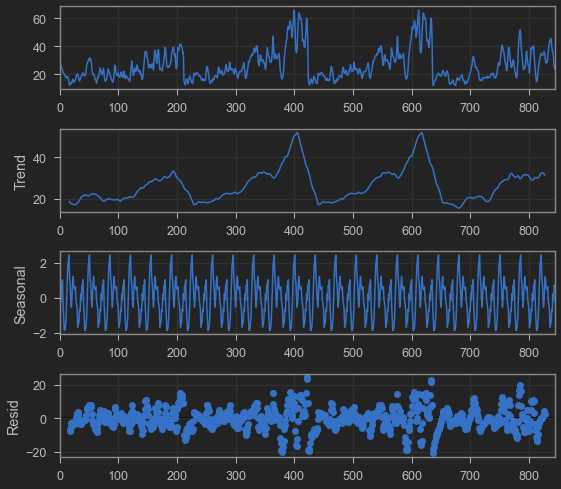

In [81]:
resultado_st = seasonal_decompose(serie_completa_suavizada,period=35)
resultado_st.plot();

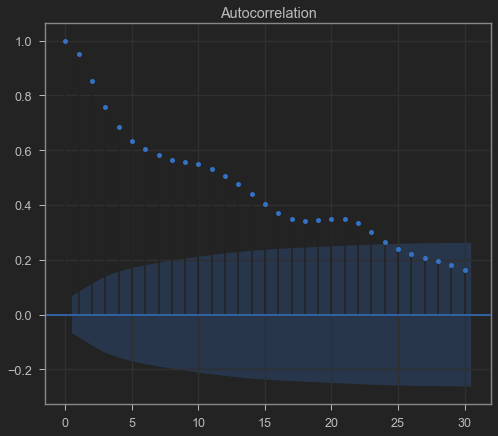

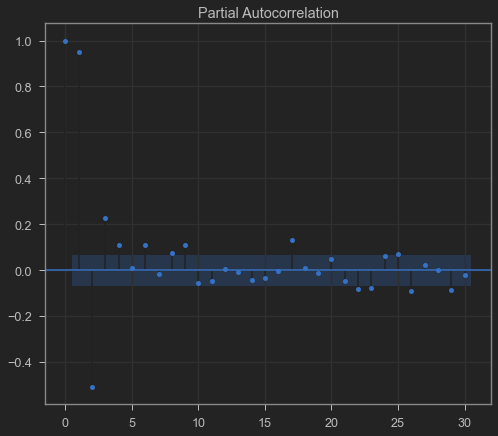

In [82]:
plot_acf(serie_completa_suavizada);
plot_pacf(serie_completa_suavizada);

# Verificando a velocidade de mundaça

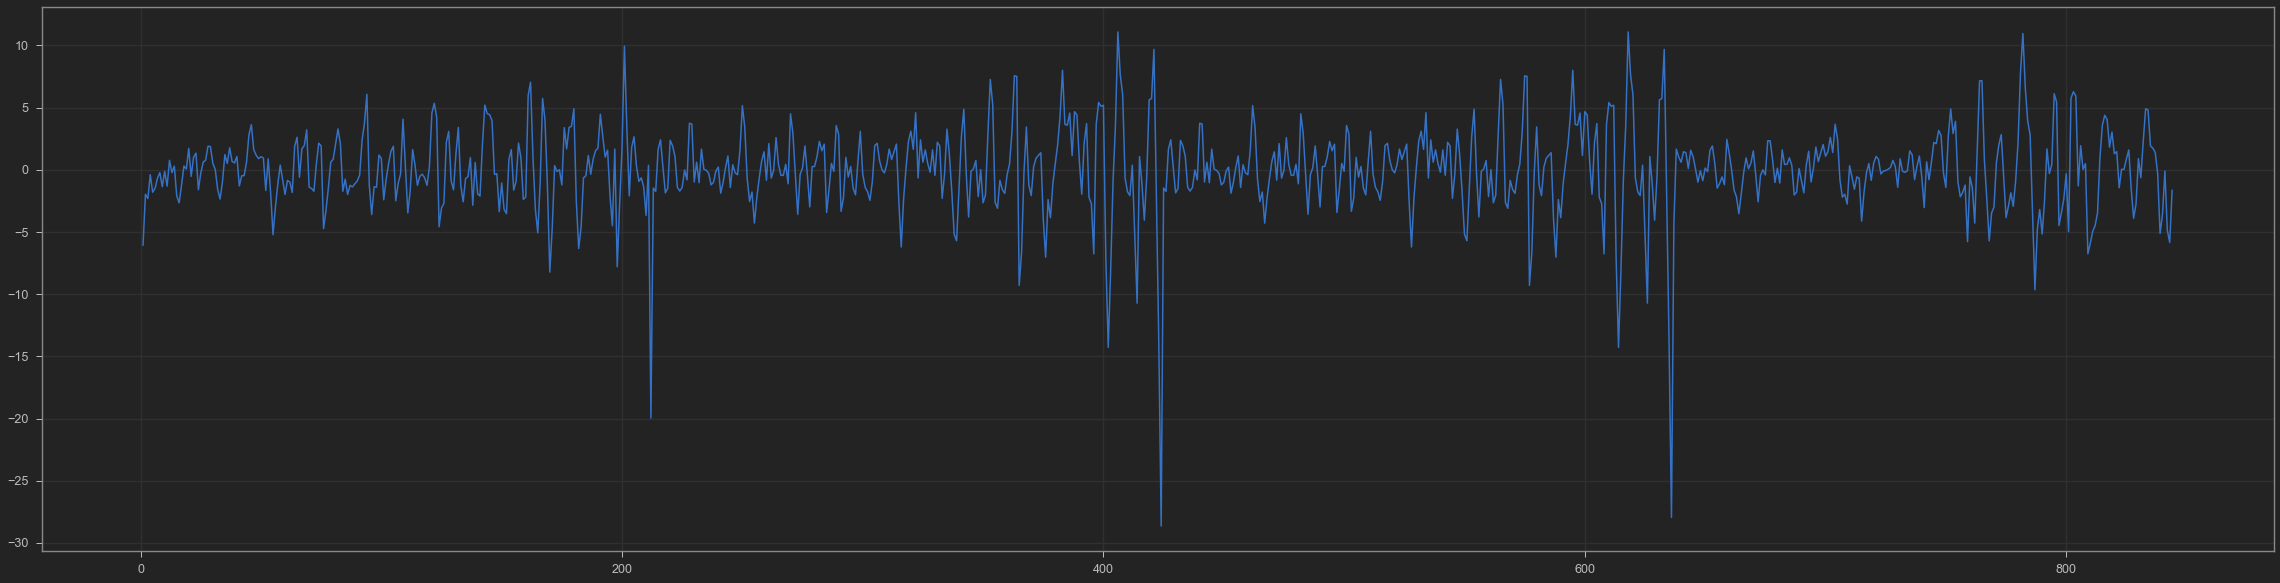

In [83]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_suavizada.diff());

# Verificando a aceleração de mundaça

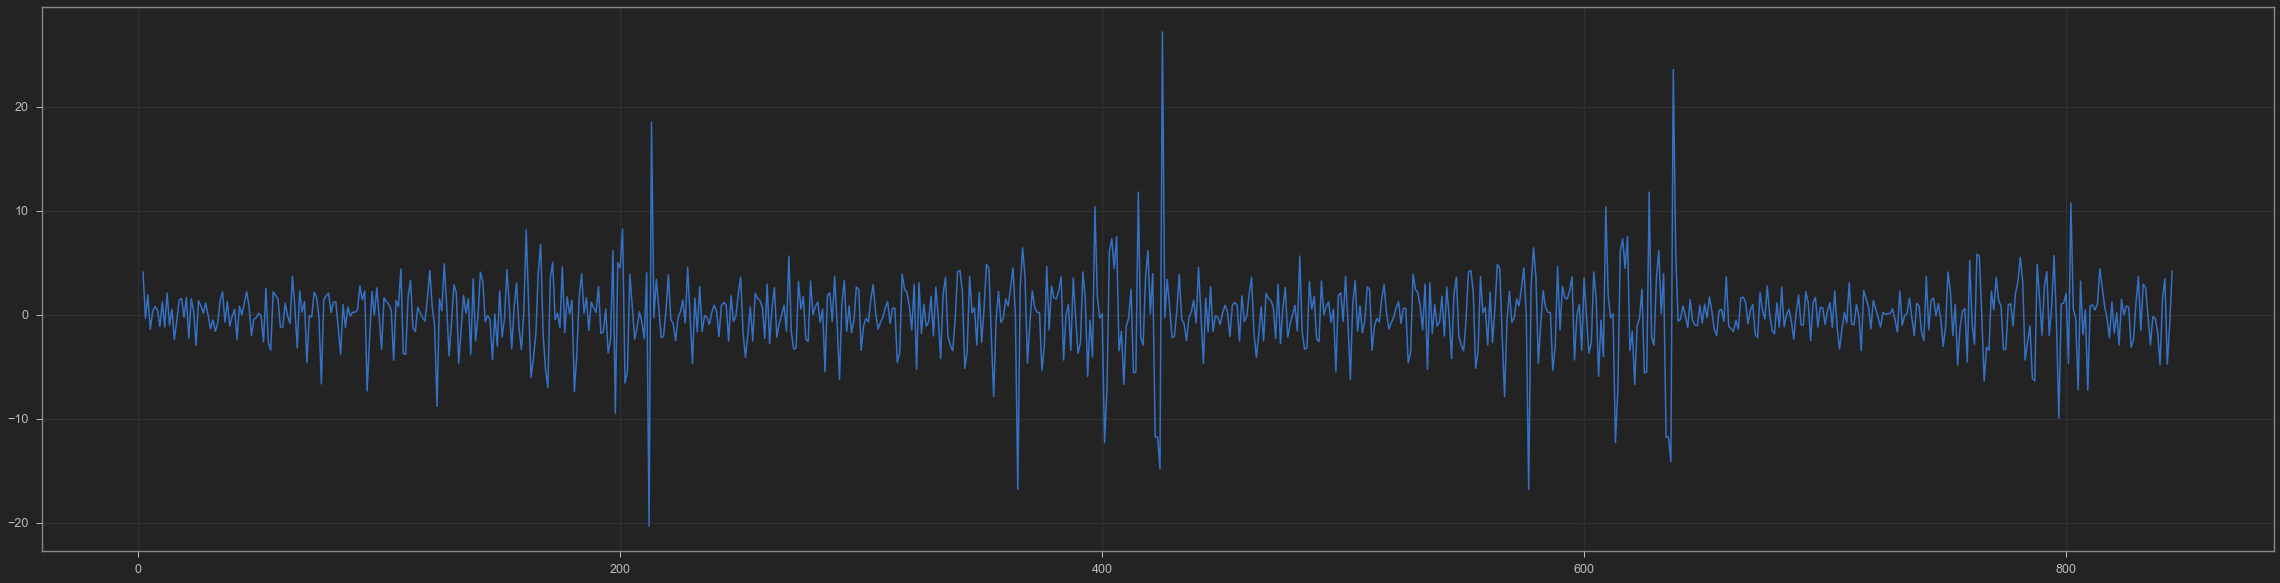

In [84]:
plt.figure(figsize=(40,10))
velocidade = serie_completa_suavizada.diff()
plt.plot(velocidade.diff());

# Jutando dados de 2016 a 2019

In [85]:
serie_completa_suavizada = pd.concat([st_2016_suavizado,st_2017_suavizado,st_2018_suavizado,st_2019_suavizado])
serie_completa_suavizada.reset_index(drop=True, inplace=True)
serie_completa_suavizada

0
0    16.408333
1    17.916667
2    21.050000
3    25.933333
4    26.141667
..         ...
840  44.770430
841  50.501801
842  60.188761
843  58.107132
844  44.274993

[845 rows x 1 columns]

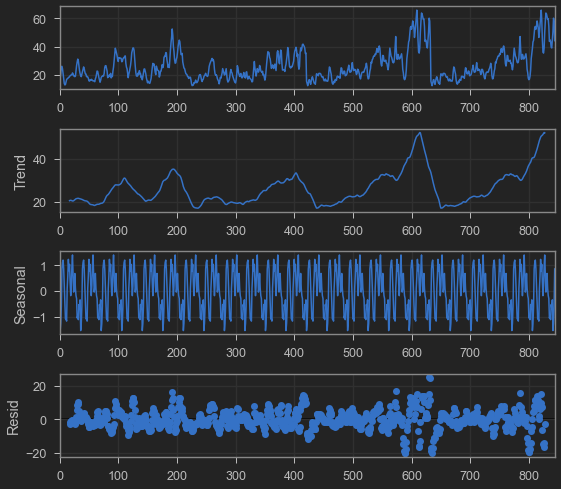

In [86]:
resultado_st = seasonal_decompose(serie_completa_suavizada,period=35)
resultado_st.plot();

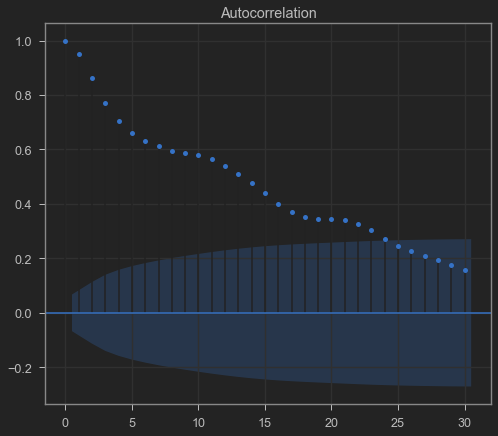

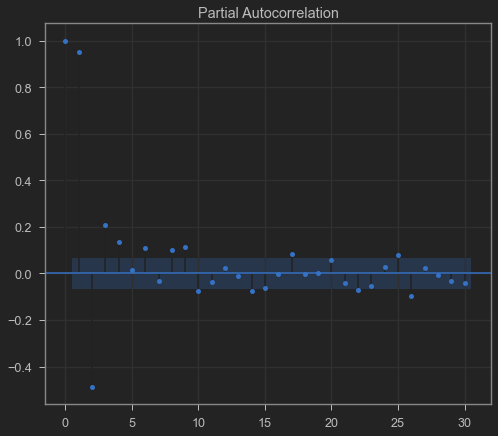

In [87]:
plot_acf(serie_completa_suavizada);
plot_pacf(serie_completa_suavizada);

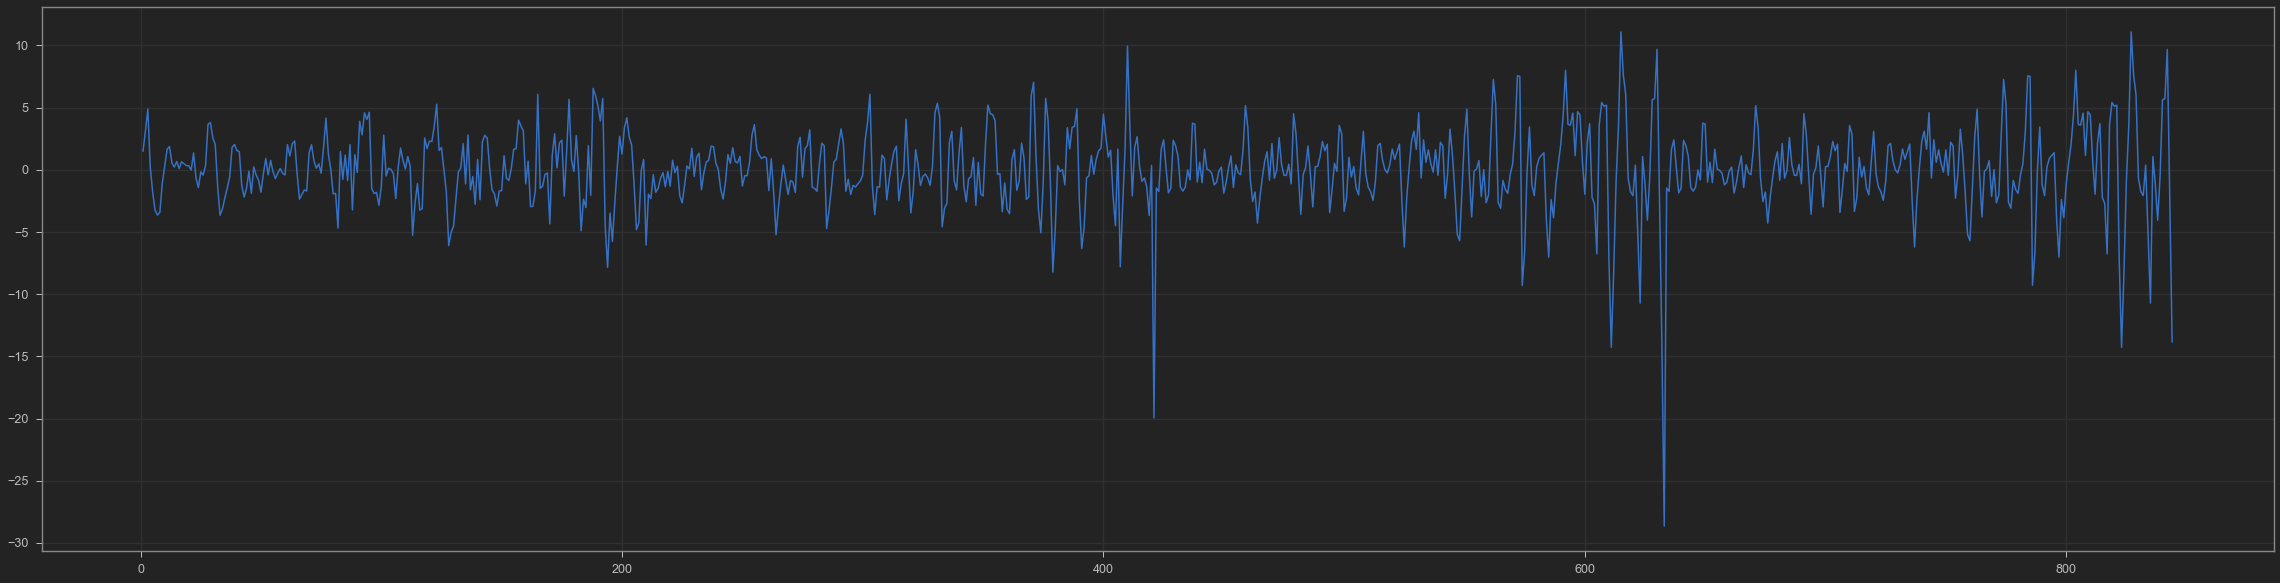

In [88]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_suavizada.diff());

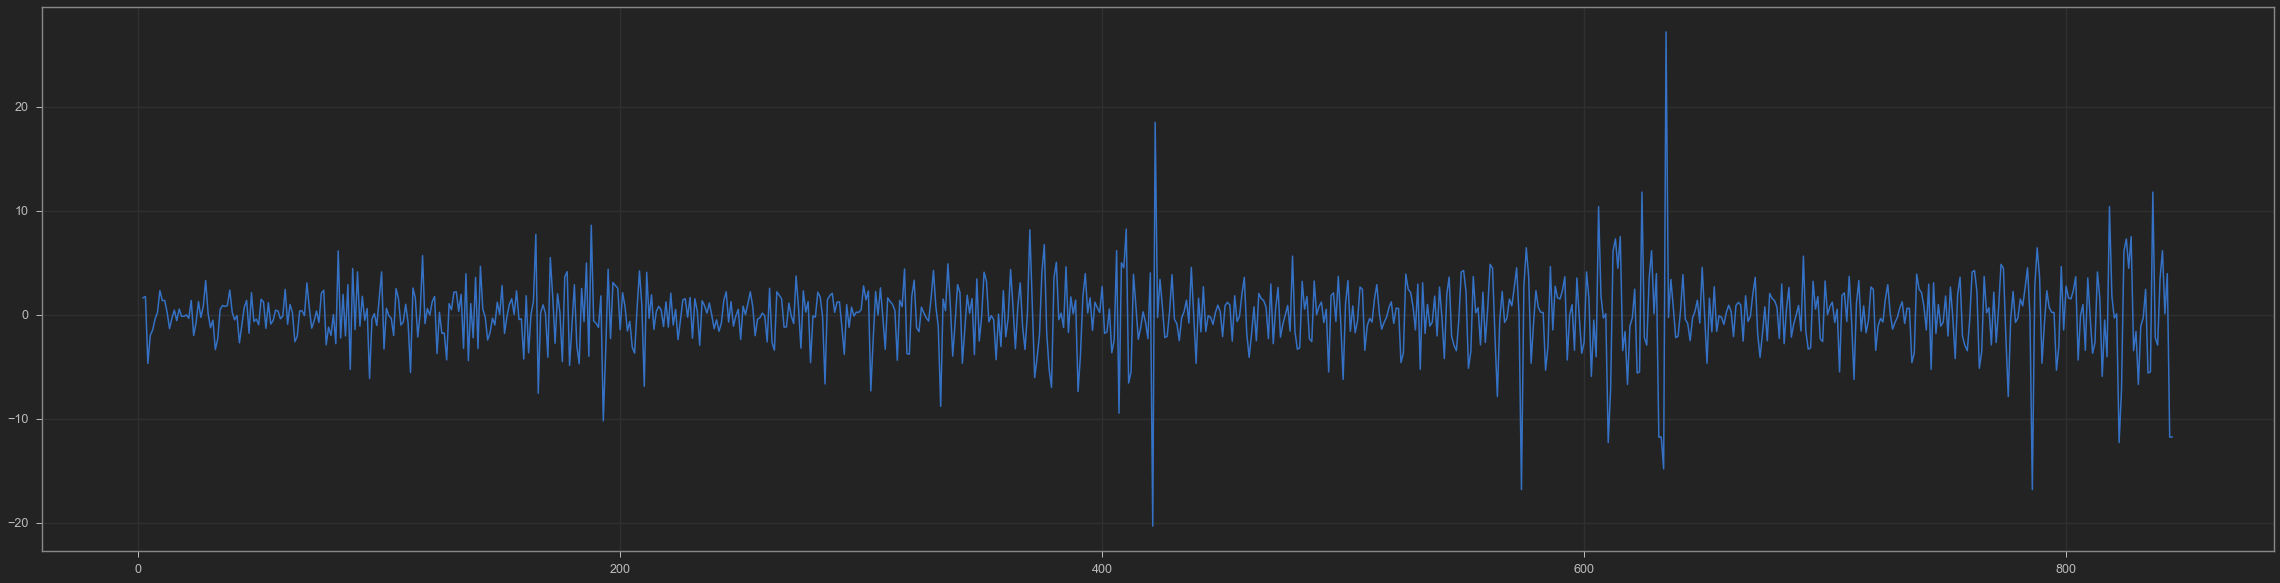

In [89]:
plt.figure(figsize=(40,10))
velocidade = serie_completa_suavizada.diff()
plt.plot(velocidade.diff());